In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from scipy import stats

from lightgbm import log_evaluation, early_stopping
import lightgbm as lgb


### Parameters

In [2]:

gap_threshold = 5 # When looking at time series data, any gap larger than this parameter is considered a break in the sequence
sequence_length = int(np.ceil ((60/gap_threshold) * 60*24)) # max possible number of reads in one day for the specific gap_threshold



#### Time Series parameters ############

#ts_aggregations = ['std', 'mean', 'min', 'max', 'skew'] # what aggregations we want to do on the parquet time series data
ts_aggregations = ['std'] # ''range', 'std', 'mean', 'min', 'max', 'skew']
pivot_features = ["week_hour"] #[ "3h", "weekday"] # how do we want to pivot the time series data

ts_aggregations_diff = ['std'] #'std', 'mean'] #, 'min', 'max', 'skew','range',]
pivot_features_diff = ["week_hour"]

filter_wear_flag_on = False

                      

time_series_aggregation_on = True
max_sequence_breaks = 1000000000
ts_params =  {'colsample_bytree': 0.9601929352092674, 'learning_rate': 0.2347885187747232, 'max_depth': 11.757995766256757, 'reg_alpha': 1.7907064273510211, 'reg_lambda': 1.1998209578340595}
ts_params =  {'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 11.313660926264719, 'reg_alpha': 0.46678721120685024, 'reg_lambda': 0.306473629655206}

ts_params =  {'colsample_bytree': 0.6053939548634096, 'learning_rate': 0.059451995869314544, 'max_depth': 5.715567522838075, 'reg_alpha': 1.898282219134133, 'reg_lambda': 1.9316077458183731}
ts_pbounds ={ 'learning_rate':        (0.01, 0.3),
            'max_depth':            (5, 16) ,
           # 'num_leaves':           (6,25),
            'colsample_bytree':     (0.01, 0.99),
            'reg_alpha':     (0.01, 2),
            'reg_lambda':     (0.01, 2)
            }


time_series_diff_aggregation_on = True
max_sequence_breaks_diff = 1000000000
#ts_params_diff =  {'colsample_bytree': 0.7470338431149504, 'learning_rate': 0.10625217855619423, 'max_depth': 8.72568252920024, 'reg_alpha': 0.3159450522178731, 'reg_lambda': 0.12064449083256262}
#ts_params_diff =   {'colsample_bytree': 0.13388348095481123, 'learning_rate': 0.04613209037998326, 'max_depth': 11.426714521456175, 'reg_alpha': 0.5846646649161501, 'reg_lambda': 0.6682133410804093}

ts_params_diff =   {'colsample_bytree': 0.5670036758072614, 'learning_rate': 0.15994593335479826, 'max_depth': 10.686235274715159, 'reg_alpha': 0.8874276627799633, 'reg_lambda': 0.9607550687386944}

#std
ts_params_diff =  {'colsample_bytree': 0.3397164927400806, 'learning_rate': 0.06957188299302025, 'max_depth': 13.35387092281375, 'reg_alpha': 0.0971940790593206, 'reg_lambda': 0.8783974774996233}
ts_diff_pbounds = { 'learning_rate':        (0.01, 0.3),
            'max_depth':            (5, 16) ,
           # 'num_leaves':           (6,25),
            'colsample_bytree':     (0.01, 0.99),
            'reg_alpha':     (0.01, 0.99),
            'reg_lambda':     (0.01, .99)
            }

bayesian_optimization_ts = False



#### Feature Engineering parameters ############

autoencoder_on =  False
imputation_on =  False
pca_components = 50

auto_encoder_epochs = 1000
auto_encoder_dimensions = 50


#### Bayesian parameters ############

bayesian_init_rounds =  15
bayesian_opt_rounds = 25

#### LGBM parameters ############

stepwise_features = -1 # if >0, we perform stepwise feature selection

bayesian_optimization = False

#lgbm_bayesian_params= {'colsample_bytree': 0.6823794822105649, 'learning_rate': 0.2301614731732811, 'max_depth': 10.801625849761404, 'reg_alpha': 1.6874131077909975, 'reg_lambda': 0.5307186645018772}
lgbm_bayesian_params= {'colsample_bytree': 0.5392080638622293, 'learning_rate': 0.22346026672581432, 'max_depth': 6.986179522202823, 'reg_alpha': 2.296985388146088, 'reg_lambda': 0.9183713307836241}
lgbm_bayesian_params={'colsample_bytree': 0.5375004629293539, 'learning_rate': 0.12203738871670142, 'max_depth': 5.0, 'reg_alpha': 2.6771459038523795, 'reg_lambda': 2.0405495674993808}
lgbm_pbounds = { 'learning_rate':        (0.001, 0.3),
            'max_depth':            (5, 16) ,
           # 'num_leaves':           (6,25),
            'colsample_bytree':     (0.01, 0.99),
            'reg_alpha':     (0.01,3),
            'reg_lambda':     (0.01,3)
            }




#### XGBoost parameters ############
xgboost_on = True
bayesian_optimization_xgb =  False
                        
#XGB_Params = {'colsample_bytree': 0.9697442313295259, 'learning_rate': 0.01, 'max_depth': 12.350315861619743, 'reg_alpha': 9.343517370820674, 'reg_lambda': 5.195984284719909}
#XGB_Params = {'colsample_bytree': 0.7992962842349717, 'learning_rate': 0.07244114289373242, 'max_depth': 12.473050505626817, 'reg_alpha': 9.605956633784812, 'reg_lambda': 9.2658047672509}
XGB_Params = {'colsample_bytree': 0.9203192422243004, 'learning_rate': 0.06858941956522761, 'max_depth': 12.064661182375076, 'reg_alpha': 9.642449802316628, 'reg_lambda': 9.376323929371848}

# std
XGB_Params = {'colsample_bytree': 0.6053939548634096,
 'learning_rate': 0.017135359956360424,
 'max_depth': 5.975773894779193,
 'reg_alpha': 9.4893665171608,
 'reg_lambda': 9.656664010414849}
xgb_pbounds = { 'learning_rate':   (0.0001, .1),
            'max_depth':            (5, 20) ,
            #'num_leaves':           (6,25),
            'colsample_bytree':     (0.01, 0.99),
            'reg_alpha':     (0.01, 10),
            'reg_lambda':     (0.01, 10)
            }         
               

    
#### Random Forest parameters ############


randomforest_on = True
bayesian_optimization_rf =  True
rf_params = {'max_depth': 18.576846841045786, 'max_samples': 0.7615907829949203, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 34.69045214759721}           

rf_pbounds = {        
        "max_depth":  (10, 20),
        "n_estimators": (20, 100) ,
        "max_samples": (0.01, 1),
        "min_samples_split": (0.01, 0.99),
        "min_samples_leaf": (0.01, .99)
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
    }      
    
custom_objective_on = True
custom_metric =  True

threshold_optimization_on = True

# Load training and test data

In [3]:
df_train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
#df_train = df_train[~pd.isnull(df_train.sii)]
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
df_train = df_train[ [c for c in df_test.columns] + ["sii"]]

categorical_features = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']



for f in categorical_features: 
    df_train[f] = df_train[f].astype('category')
    df_test[f] = df_test[f].astype('category')  

    
print(df_train.shape, df_test.shape)

(3960, 60) (20, 59)


### Time series ( parquet ) files

In [4]:
# We'll gather basic metadata about the parquet files. In particular we want to understand if there are breaks in the sequence
# so that we can decide whether the file is good enough for our analysis
#
# For descriptive data analysis ( mean, std, min, max) we can work with all files
# For sequence analysis ( through CNN, LSTM ) we want to work with continous sequences only


def analyze_ts_files(directory_path, gap_threshold= 5.0):
    
    folder_names = [f for f in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, f))]

    dfs = []
    row_count = 0
    i = 0
    df_results = pd.DataFrame()
    for folder_name in folder_names:
        folder_path = os.path.join(directory_path, folder_name)
        parquet_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.parquet')]
        df_folder = pd.DataFrame()

        df_folder = pd.DataFrame({"folder": [folder_name[3:]] * len(parquet_files), "files" : parquet_files})
        df_temp = pd.read_parquet(parquet_files[0])
        df_temp["time_of_day"] = df_temp.time_of_day/1000000000
        df_temp["time_of_day"] = df_temp["time_of_day"].astype(np.int32)
        df_temp["time_of_day_diff"] = df_temp["time_of_day"].diff()

        sequence_breaks = df_temp[df_temp.time_of_day_diff > gap_threshold].shape[0]

        min_break = df_temp[(~pd.isnull(df_temp.time_of_day_diff)) & (df_temp.time_of_day_diff > gap_threshold)].time_of_day_diff.min()
        max_break = df_temp[(~pd.isnull(df_temp.time_of_day_diff)) & (df_temp.time_of_day_diff > gap_threshold)].time_of_day_diff.max()
        d= {"folder_name": folder_name, "file": parquet_files[0], "sequence_breaks": sequence_breaks, "record_count" : df_temp.shape[0],  "min_break": min_break, "max_break": max_break, "threshold" : gap_threshold}
        df_results = pd.concat([df_results, pd.DataFrame(d, index=[0])], ignore_index=True)

  
    return df_results

In [5]:
file_path = f"/kaggle/input/dataset-piu/piu/timeseries_{gap_threshold}.csv" 
if os.path.exists(file_path):
    ts_df = pd.read_csv(file_path)
else:
    directory_path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/'
    ts_df = analyze_ts_files(directory_path, gap_threshold)
    ts_df.to_csv(file_path, index = None)


ts_df["id"] = ts_df["folder_name"].str[3:]
ts_df = ts_df.merge(df_train[["id", "sii"]], on="id", how="inner")
ts_df["sii"] = ts_df["sii"].astype(np.int8)

# Time series feature extraction

In [6]:

# Aggregate the metrics in the parquet files 
from scipy import stats
from scipy import stats

def timeseries_aggregation(df, aggregation, aggregation_columns):

    df_ts_agg = pd.DataFrame()
    for index, row in df.iterrows():             

        file_path = row["file"]
        rowid  = row["id"]
        df = pd.read_parquet(file_path)
        df[ "non-wear_flag"] = df["non-wear_flag"].astype(np.int8)

            
        df["time_of_day"] = df.time_of_day / 1000000000
        df["time_of_day"] = df["time_of_day"].astype(np.int32)
        df["id"] =  row["id"]
        df['magnitude'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
        #remove the first day if not complete
        if df.iloc[0].time_of_day > 10:
            first_day = df["relative_date_PCIAT"].iloc[0]
            df = df[df["relative_date_PCIAT"] != first_day]

        if (df.shape[0] == 0): continue

        #remove the last day if not complete
        if df.iloc[-1].time_of_day < 60 * 60*24 - 10:
            last_day = df["relative_date_PCIAT"].iloc[-1]
            df = df[df["relative_date_PCIAT"] != last_day]


        df['hour_of_day'] = (df['time_of_day'] // 3600).astype(int)
        df['10min'] = (df['time_of_day'] // 600).astype(int)
        df['3h'] = (df['time_of_day'] // 14400).astype(int)
        df['week_3h'] = df['weekday'].astype(str) + "_" + df['3h'].astype(str)
        df["week_hour"] = df['weekday'].astype(str) + "_" + df['hour_of_day'].astype(str)

      
        cols = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light',  'battery_voltage']
        if filter_wear_flag_on :
            df = df[df["non-wear_flag"] == 0 ]
        else:
            cols.append('non-wear_flag')

        if (df.shape[0] == 0): continue
        if aggregation == 'kurt':
            df_agg_by_date = df[cols + ['id', 'relative_date_PCIAT'] + aggregation_columns
           ].groupby(aggregation_columns + ['id', 'relative_date_PCIAT']).agg(stats.kurtosis).reset_index()
        
        elif aggregation == 'range':            
            df_agg_by_date = df[cols + ['id', 'relative_date_PCIAT'] + aggregation_columns
           ].groupby(aggregation_columns + ['id', 'relative_date_PCIAT']).agg(['min', 'max']).reset_index()
            df_agg_by_date.columns = list(map('_'.join, df_agg_by_date.columns.values))
            #display(df_agg_by_date) 
            
            for c in cols:
                df_agg_by_date[f"{c}"] =  df_agg_by_date[f"{c}_max"] -  df_agg_by_date[f"{c}_min"]
            df_agg_by_date.rename( columns = {"id_": 'id', 'relative_date_PCIAT_': 'relative_date_PCIAT'}, inplace = True)
            for c in aggregation_columns:
                df_agg_by_date.rename( columns = { f"{c}_" : c }, inplace = True)
            
            df_agg_by_date = df_agg_by_date[cols + ['id', 'relative_date_PCIAT'] + aggregation_columns]
            
        else:    
            df_agg_by_date = df[cols + ['id', 'relative_date_PCIAT'] + aggregation_columns].groupby(aggregation_columns + ['id', 'relative_date_PCIAT']).agg(aggregation).reset_index()

            
        df_agg = df_agg_by_date[cols + ['id'] + aggregation_columns].groupby(aggregation_columns + ['id']).agg('mean').reset_index()
    
        # We are going to calculate the stats by the hour ( for example) and then average them accross days
        df_agg['activity_range']: hourly_activity.max() - hourly_activity.min()
        df_ts_agg = pd.concat([df_ts_agg, df_agg], ignore_index = True)

    return df_ts_agg


def timeseries_aggregation_diff(df, aggregation, aggregation_columns, full_days_only = False):

    df_ts_agg = pd.DataFrame()
    for index, row in df.iterrows():             

        file_path = row["file"]
        rowid  = row["id"]
        df = pd.read_parquet(file_path)
        df[ "non-wear_flag"] = df["non-wear_flag"].astype(np.int8)
        
        df["time_of_day"] = df.time_of_day / 1000000000
        df["time_of_day"] = df["time_of_day"].astype(np.int32)

        df["id"] =  row["id"]

        #remove the first day if not complete
        if full_days_only:
            if df.iloc[0].time_of_day > 10:
                first_day = df["relative_date_PCIAT"].iloc[0]
                df = df[df["relative_date_PCIAT"] != first_day]

            if (df.shape[0] == 0): continue        
            #remove the last day if not complete

            if df.iloc[-1].time_of_day < 60 * 60*24 - 10:
                last_day = df["relative_date_PCIAT"].iloc[-1]
                df = df[df["relative_date_PCIAT"] != last_day]
                
            
        df["time_of_day_diff"] = df["time_of_day"].diff()    
        cols = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light', 'battery_voltage']
        if filter_wear_flag_on :
            df = df[df["non-wear_flag"] == 0 ]
        else:
            cols.append('non-wear_flag')
        
        #if (df.shape[0] == 0): continue
        diff_cols = []
        for c in cols:
            df[f'diff_{c}'] = df[c].diff()
            df.loc[df["time_of_day_diff"] > 5, f'diff_{c}'] = 0
            diff_cols.append(f'diff_{c}')
            
        df["distance"] = df['diff_X'] * df['diff_X']  + df['diff_Y'] *  df['diff_Y']  + df['diff_Z'] * df['diff_Z'] 
        diff_cols.append("distance")

        if (df.shape[0] == 0): continue

        df['hour_of_day'] = (df['time_of_day'] // 3600).astype(int)
        df['10min'] = (df['time_of_day'] // 600).astype(int)
        df["week_hour"] = df['weekday'].astype(str) + "_" + df['hour_of_day'].astype(str)
        df['3h'] = (df['time_of_day'] // 14400).astype(int)
        df['week_3h'] =  df['weekday'].astype(str) + "_" + df['3h'].astype(str)

        if aggregation == 'kurt':
            df_agg_by_date = df[diff_cols + ['id', 'relative_date_PCIAT'] + aggregation_columns].groupby(aggregation_columns + ['id', 'relative_date_PCIAT']).agg(stats.kurtosis).reset_index()

        elif aggregation == 'range':            
            df_agg_by_date = df[diff_cols + ['id', 'relative_date_PCIAT'] + aggregation_columns
           ].groupby(aggregation_columns + ['id', 'relative_date_PCIAT']).agg(['min', 'max']).reset_index()
            df_agg_by_date.columns = list(map('_'.join, df_agg_by_date.columns.values))
            #display(df_agg_by_date) 
            
            for c in diff_cols:
                df_agg_by_date[f"{c}"] =  df_agg_by_date[f"{c}_max"] -  df_agg_by_date[f"{c}_min"]
            df_agg_by_date.rename( columns = {"id_": 'id', 'relative_date_PCIAT_': 'relative_date_PCIAT'}, inplace = True)
            for c in aggregation_columns:
                df_agg_by_date.rename( columns = { f"{c}_" : c }, inplace = True)
            
            df_agg_by_date = df_agg_by_date[diff_cols + ['id', 'relative_date_PCIAT'] + aggregation_columns]

            #display(df_agg_by_date)
        else: 
            df_agg_by_date = df[diff_cols + ['id', 'relative_date_PCIAT'] + aggregation_columns].groupby(aggregation_columns + ['id', 'relative_date_PCIAT']).agg(aggregation).reset_index()
        
        
        # We are going to calculate the stats by the hour ( for example) and then average them accross days
        df_agg = df_agg_by_date[diff_cols + ['id'] + aggregation_columns].groupby(aggregation_columns + ['id']).agg('mean').reset_index()

        df_ts_agg = pd.concat([df_ts_agg, df_agg], ignore_index = True)

    return df_ts_agg


In [7]:
# Pivoting the values so that we have for each id, aggregations for hour 1,2,3,  or weekdays,or weekday-hour 
def ts_pivot_by_feature(df_ts_agg, pivot_feature, cols):
    #cols = ['X', 'Y', 'Z', 'enmo', 'anglez']
    #cols = ['diff_X', 'diff_Y', 'diff_Z', 'diff_enmo', 'diff_anglez']
    df_features = df_ts_agg[["id"]].drop_duplicates()

    for col in cols:
        #print( "pivoting column ", col)
        df_temp = df_ts_agg[['id', pivot_feature, col]].pivot(index='id', columns=pivot_feature, values=col).reset_index()
        df_temp.columns = [ 'id'] + [ str(col) + '_' + str(c) for c in df_temp.columns if c != 'id']
        df_features = df_features.merge(df_temp, on = "id", how = "left")
    
    return df_features    

In [8]:
      

def ts_aggregation_features(ts_df, ts_aggregations, pivot_features, timeseries_aggregation_function, file_prefix, pivot_cols):
    #caching the preprocessed data in the working directory to avoid recalculations
    df_ts_features = ts_df[["id"]].copy()
    features = [] # We need to do this for the cached features
    for ts_aggregation in ts_aggregations:
        for pivot_feature in pivot_features:
            #file_path = f"/kaggle/input/dataset-piu/piu/{file_prefix}_{pivot_feature}_{ts_aggregation}_{gap_threshold}_{ts_df.shape[0]}_2levels.csv" 
            file_path = f"/kaggle/input/dataset-piu/piu/{file_prefix}_{pivot_feature}_{ts_aggregation}_{gap_threshold}_{ts_df.shape[0]}_addtional_2levels.csv" 

            print(file_path)
            if os.path.exists(file_path):
                df_temp = pd.read_csv(file_path)
                df_temp.columns = [ 'id'] + [ pivot_feature + '_' + ts_aggregation + '_' + c for c in df_temp.columns if c != 'id']
                df_ts_features = df_ts_features.merge(df_temp, on = "id", how = "left")
            else:
                print( ts_aggregation, pivot_feature)
                df_ts_agg =  timeseries_aggregation_function(ts_df, ts_aggregation, [pivot_feature])    


                df_temp = ts_pivot_by_feature(df_ts_agg, pivot_feature, pivot_cols)
                df_temp.to_csv(file_path, index = None)
                df_temp.columns = [ 'id'] + [ pivot_feature + '_' + ts_aggregation + '_' + c for c in df_temp.columns if c != 'id']
                df_ts_features = df_ts_features.merge(df_temp, on = "id", how = "left")
    print(df_ts_features.shape)
    return df_ts_features



    
            


In [9]:
#To start off, we'll focus only on those time series that have no breaks


#ts_df = ts_df[ts_df.sequence_breaks == 0]
#ts_df.head()

In [10]:

#This is the evaluation metric used by LGBM, see parameters
def quadratic_weighted_kappa(y_true, y_pred):
    #y_true = y_true
    y_pred = y_pred.clip(y_min, y_max).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True

y_min = int(df_train.sii.min())
y_max = int(df_train.sii.max())

a = 2.998
b = 1.092

#still looking into this
def quadratic_weighted_kappa_obj(y_true, y_pred):
    y_true1 = (y_true + a).clip(y_min, y_max).round()
    y_pred1 = (y_pred + a).clip(y_min, y_max).round()
    #qwk = cohen_kappa_score(y_true.clip(0, 4).round(), y_pred, weights="quadratic")
    qwk = cohen_kappa_score(y_true1, y_pred1, weights="quadratic")
    return 'QWK', qwk, True



def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess



In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

def quadratic_kappa(y_true, y_pred):
    
    y_pred1 = y_pred.clip(y_min, y_max).round()
    return cohen_kappa_score(y_true, y_pred1, weights='quadratic')


In [12]:
def train_timeseries_model(df_train, df_ts_features, params, prediction_field):
   

    df_train_ts = df_train.merge(df_ts_features, on  = "id", how = "inner")
    features = [ c for c in df_ts_features.columns if c not in [ "id"]]
    X = df_train_ts[features]
    y = df_train_ts["sii"].astype(int)
    print(X.shape, y.shape)
    
    callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
    ts_training_predictions = np.zeros((df_train_ts.shape[0],))
    i=1
    ts_models = []
    sum_kappa = 0
    for train_index, test_index in skf.split(X, y):   
        print('fold',i)
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]   
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]  
        model = lgb.LGBMRegressor(
                objective = qwk_obj if custom_objective_on else None ,
                metrics = 'None',
                learning_rate = params["learning_rate"],
                max_depth = round(params["max_depth"]),
                num_leaves = 2^(round(params["max_depth"] ) - 1),
                colsample_bytree=params["colsample_bytree"],
                reg_alpha = params["reg_alpha"],
                reg_lambda = params["reg_lambda"],
                n_estimators=n_estimators,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
                verbosity = - 1)

        model.fit(X_train_fold,y_train_fold, 
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric= quadratic_weighted_kappa if custom_metric else None,
                                  callbacks=callbacks)
        ts_models.append(model)
        predictions_fold = model.predict(X_test_fold)
        ts_training_predictions [test_index] = predictions_fold
        f1_fold = f1_score(y_test_fold, predictions_fold.clip(y_min, y_max).round(), average='weighted')

        kappa_fold = cohen_kappa_score(y_test_fold, predictions_fold.clip(y_min, y_max).round(), weights='quadratic')
        sum_kappa += kappa_fold
        print( f1_fold, kappa_fold)
        i+= 1
        
    print("mean kappa" , sum_kappa/n_splits)
    df_train_ts[prediction_field] = ts_training_predictions
    return df_train_ts, ts_models


In [13]:
def display_progress(event, instance):
    iter = len(instance.res) - 1
    print('Iteration: {} - Kappa: {} - {}'.format(iter, instance.res[iter].get('target'), instance.res[iter].get('params')))

In [14]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

def bayesian_parameter_optimization( init_rounds, opt_rounds, parameter_bounds, evaluator):


    optimizer = BayesianOptimization(f = evaluator, 
                                    pbounds = parameter_bounds,
                                    random_state = 42,
                                    verbose = 2)

    logger = JSONLogger(path = f'bayesian_parameter_output.json')
    optimizer.subscribe("optimization:step", logger)

    optimizer.subscribe("optimization:step", " ", display_progress)

    optimizer.maximize(init_points = init_rounds, n_iter = opt_rounds)

    return optimizer.max

In [15]:
def lgbm_cv_evaluator(learning_rate, max_depth, colsample_bytree,reg_alpha, reg_lambda):

    callbacks = [log_evaluation(period=100), early_stopping(stopping_rounds=75,first_metric_only=True)]

    i = 0
   # f1_scores = []
    kappa_scores = []
    for train_index, test_index in skf.split(X, y):

        print('fold',i+1, X.shape, y.shape, type(y))
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        
        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y[test_index]

        model = lgb.LGBMRegressor(
                    objective = qwk_obj if custom_objective_on else None,
                    metrics = 'None',
                    learning_rate = learning_rate,
                    max_depth = round(max_depth),
                    num_leaves = 2^ (round(max_depth) - 1),
                    colsample_bytree=colsample_bytree,
                    reg_alpha =reg_alpha,
                    reg_lambda = reg_lambda,
                    n_estimators=n_estimators,
                    random_state=42,
                    #extra_trees=True,
                    #class_weight='balanced',
                    verbosity = - 1,
                    verbose_eval=False)

        predictor = model.fit(X_train_fold,
                                y_train_fold,
                                eval_names=['train', 'valid'],
                                eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                eval_metric= quadratic_weighted_kappa if custom_metric else None,
                                callbacks=callbacks

                                 )

        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold
        predictions_fold = predictions_fold.clip(y_min, y_max).round()


        kappa_fold = quadratic_kappa(y_test_fold_int, predictions_fold)

        kappa_scores.append(kappa_fold)

        print(f'Cohen kappa score across fold: {kappa_fold}')
        i+=1

    mean_kappa_score = np.mean(kappa_scores)


    print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')
    return mean_kappa_score

In [16]:
if time_series_diff_aggregation_on:
       
    n_splits = 5
    n_estimators = 500
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    pivot_columns = ['diff_X', 'diff_Y', 'diff_Z', 'diff_enmo', 'diff_anglez', 'diff_light','distance', 'diff_battery_voltage']
    if not filter_wear_flag_on :
        pivot_columns.append('diff_non-wear_flag')

    ts_df_diff = ts_df[ts_df.sequence_breaks <= max_sequence_breaks_diff]
    df_ts_diff_features =  ts_aggregation_features(ts_df_diff, ts_aggregations_diff, pivot_features_diff, timeseries_aggregation_diff, "ts_diff_features_agg", pivot_columns)
    print(df_ts_diff_features.shape)
    features = ['id']
    for pivot in pivot_columns:
        
        features.extend([c for c in df_ts_diff_features.columns if pivot in c])

    df_ts_diff_features = df_ts_diff_features[features]
    lgbm_params = ts_params_diff
    if bayesian_optimization_ts:
        df_train_ts = df_train.merge(df_ts_diff_features, on  = "id", how = "inner")
        features = [ c for c in df_ts_diff_features.columns if c not in [ "id"]]
        X = df_train_ts[features]
        y = df_train_ts["sii"].astype(int)
        print(X.shape, y.shape)
        max_params = bayesian_parameter_optimization( init_rounds = bayesian_init_rounds, opt_rounds = bayesian_opt_rounds, parameter_bounds = ts_diff_pbounds, evaluator = lgbm_cv_evaluator)
        lgbm_params = max_params['params']
        print("new LGBM bayesian params:", lgbm_params)    
    
    df_train_diff_ts, ts_diff_models = train_timeseries_model(df_train, df_ts_diff_features, lgbm_params, "ts_predictions_diff")
    df_train = df_train.merge(df_train_diff_ts[["ts_predictions_diff", "id"]], on  = "id", how = "left")
    

/kaggle/input/dataset-piu/piu/ts_diff_features_agg_week_hour_std_5_996_addtional_2levels.csv
(996, 1513)
(996, 1513)
(996, 1512) (996,)
fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.557759	valid's QWK: 0.193154
[50]	train's QWK: 0.779781	valid's QWK: 0.205379
[75]	train's QWK: 0.905891	valid's QWK: 0.171943
Early stopping, best iteration is:
[12]	train's QWK: 0.477454	valid's QWK: 0.212694
Evaluated only: QWK
0.44068357998590557 0.21269379844961245
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.58201	valid's QWK: 0.136017
[50]	train's QWK: 0.775517	valid's QWK: 0.138316
[75]	train's QWK: 0.894824	valid's QWK: 0.23152
Early stopping, best iteration is:
[10]	train's QWK: 0.497782	valid's QWK: 0.248832
Evaluated only: QWK
0.5363747543574983 0.2488316357100061
fold 3
[LightGBM] [Info] Using self-de

In [17]:
if time_series_aggregation_on:
    n_splits = 5
    n_estimators = 500
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    pivot_columns = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light', 'battery_voltage']
    if not filter_wear_flag_on :
        pivot_columns.append('non-wear_flag')
    ts_df = ts_df[ts_df.sequence_breaks <= max_sequence_breaks]
    #ts_df_diff = ts_df.copy()
    df_ts_features =  ts_aggregation_features(ts_df, ts_aggregations, pivot_features, timeseries_aggregation, "ts_features_agg", pivot_columns)
    print(df_ts_features.shape)
    features = ['id']
    for pivot in pivot_columns:
        
        features.extend([c for c in df_ts_features.columns if pivot in c])

    df_ts_features = df_ts_features[features]
    #print(df_ts_diff_features.shape, len(features))
    #params = {'learning_rate': 0.01, 'max_depth': 30, 'n_estimators': 225, 'num_leaves': 75}
    df_train_ts = df_train.merge(df_ts_features, on  = "id", how = "inner")
    features = [ c for c in df_ts_features.columns if c not in [ "id"]]
    X = df_train_ts[features]
    y = df_train_ts["sii"].astype(int)
    print(X.shape, y.shape)
    
    lgbm_params = ts_params
    if bayesian_optimization_ts:
        
        max_params = bayesian_parameter_optimization( init_rounds = bayesian_init_rounds, opt_rounds = bayesian_opt_rounds, parameter_bounds = ts_pbounds, evaluator = lgbm_cv_evaluator)
        lgbm_params = max_params['params']
        print("new LGBM bayesian params:", lgbm_params)    
    df_train_ts, ts_models = train_timeseries_model(df_train, df_ts_features, lgbm_params, "ts_predictions")
    

    df_train = df_train.merge(df_train_ts[["ts_predictions", "id"]], on  = "id", how = "left")
 


/kaggle/input/dataset-piu/piu/ts_features_agg_week_hour_std_5_996_addtional_2levels.csv
(996, 1345)
(996, 1345)
(996, 1344) (996,)
(996, 1344) (996,)
fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.345027	valid's QWK: 0.108923
[50]	train's QWK: 0.423869	valid's QWK: 0.1
[75]	train's QWK: 0.554544	valid's QWK: 0.117793
[100]	train's QWK: 0.657025	valid's QWK: 0.160079
[125]	train's QWK: 0.733269	valid's QWK: 0.143836
[150]	train's QWK: 0.788472	valid's QWK: 0.103659
[175]	train's QWK: 0.839618	valid's QWK: 0.0828474
Early stopping, best iteration is:
[102]	train's QWK: 0.662305	valid's QWK: 0.179418
Evaluated only: QWK
0.4047091169674457 0.17941757156959515
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.348911	valid's QWK: 0.11478
[50]	train's QWK: 0.438162	valid's QWK: 0.0555849
[75]	train's QWK:

(996, 2857) 2856


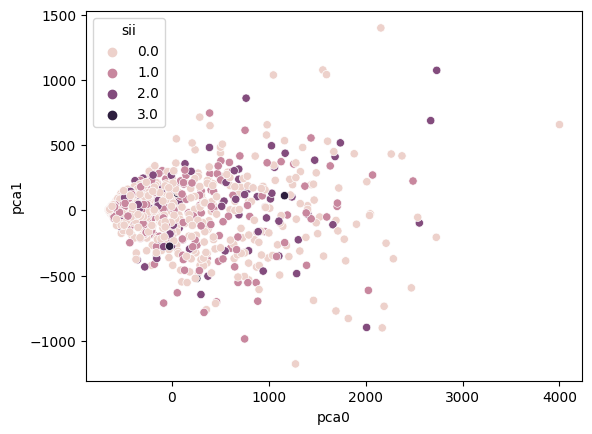

In [18]:
from sklearn.decomposition import PCA
if pca_components > 0:
    #n_components = 20
    df_ts_all_features  = df_ts_diff_features.merge(df_ts_features, on = "id")
    pca_numeric_cols = df_ts_all_features.select_dtypes(include=['float64', 'int64']).columns
    print(df_ts_all_features.shape, len(pca_numeric_cols))

    #display(df_ts_diff_features.loc[:, df_ts_diff_features.isnull().any()])

    pca_cols = [ c for c in pca_numeric_cols if c not in [ 'id', 'sii']]
    pca_X = df_ts_all_features[pca_cols].copy()
    pca_X.fillna(0, inplace =  True)
    pca = PCA(n_components=pca_components)
    #pca.fit(pca_X)
    reduced_X = pca.fit_transform(pca_X)
    #PCA(n_components=2)

    import seaborn as sns
    pca_df  = pd.DataFrame(reduced_X)
    pca_columns = [ f"pca{i}" for i in range(pca_components)] 
    pca_df.columns =  pca_columns
    pca_df["sii"] = df_train_diff_ts["sii"]
    pca_df["id"] = df_train_diff_ts["id"]

    #pca.components_.shape, X.shape, newdf.shape

    sns.scatterplot(pca_df, x = "pca0", y = "pca1", hue = "sii")
    #newdf.head()

    df_train = df_train.merge(pca_df[ pca_columns + ["id"]] , on  = "id", how = "left")
    
    
    
  


In [19]:
def tabular_feature_engineering(df):
    #season_cols = [col for col in df.columns if 'Season' in col]
    #df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [20]:
import torch.nn as nn
import torch.optim as optim
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch


def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    #
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    autoencoder = autoencoder.to(device)
    data_tensor = data_tensor.to(device)
    #
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            batch.to(device)
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).cpu().numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded



In [21]:
if autoencoder_on:
    #train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
    #test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

    #train_ts_encoded = perform_autoencoder(train_ts.drop('id', axis=1), encoding_dim=60, epochs=100, batch_size=32)
    #test_ts_encoded = perform_autoencoder(test_ts.drop('id', axis=1), encoding_dim=60, epochs=100, batch_size=32)
   
    #autoenc_numeric_cols = df_ts_all_features.select_dtypes(include=['float64', 'int64']).columns

    df_ts_all_features  = df_ts_diff_features.merge(df_ts_features, on = "id")
    df_ts_all_features  = df_ts_diff_features #.merge(df_ts_features, on = "id")
    cols = [c for c in df_ts_all_features.columns if c not in ["id"]]
    #cols = [ c for c in numeric_cols if c not in [ 'id', 'sii']]
    unencoded_df = df_ts_all_features[cols].copy()
    print("Auto-encoding ", unencoded_df.shape)
    unencoded_df.fillna(0, inplace =  True)
    
    train_ts_encoded = perform_autoencoder(unencoded_df, encoding_dim=auto_encoder_dimensions, epochs=auto_encoder_epochs, batch_size=16)
    #test_ts_encoded = perform_autoencoder(df_ts_diff_features, encoding_dim=60, epochs=100, batch_size=32)
    train_ts_encoded["id"] = df_ts_all_features["id"]
    
    time_series_cols = train_ts_encoded.columns.tolist()
    #train_ts_encoded["id"]=df_train_ts["id"]
    #test_ts_encoded['id']=test_ts["id"]


    df_train = df_train.merge(train_ts_encoded, on  = "id", how = "left")
    print(df_train.shape)

In [22]:
df_train = df_train[~pd.isnull(df_train.sii)]
print(df_train.shape)

(2736, 112)


In [23]:
df_train = tabular_feature_engineering(df_train)
print(df_train.shape)

(2736, 127)


In [24]:
features = [ c for c in df_train.columns if c not in [ "id", "sii"]]
X = df_train[features]
y = df_train["sii"].astype(int).to_numpy()
print(X.shape, y.shape)


numeric_X = pd.get_dummies(X, columns = categorical_features)
print(numeric_X.shape)

(2736, 125) (2736,)
(2736, 155)


# LGBM

In [25]:
params = lgbm_bayesian_params
if bayesian_optimization:
    n_splits = 5
    n_estimators = 500
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    max_params = bayesian_parameter_optimization( init_rounds = bayesian_init_rounds, opt_rounds = bayesian_opt_rounds, parameter_bounds = lgbm_pbounds, evaluator = lgbm_cv_evaluator)
    params = max_params['params']
    print("new LGBM bayesian params:", params)

In [26]:
# We want to store the predictions for each fold both real and discrete for ensemble or threshold purposes

training_predictions = np.zeros((df_train.shape[0],))
training_clipped_predictions = np.zeros((df_train.shape[0],))
training_predictions.shape

(2736,)

In [27]:
if stepwise_features > 0:
    n_splits = 5
    n_estimators = 500

    #stratified K fold based on classes
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    f1_scores = []
    kappa_scores = []
    models = []
    predictions = []


    features = [ c for c in df_train.columns if c not in [ "id", "sii"]]


    #y = df_train["sii"].astype(int)
    print(X.shape, y.shape)


    callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]

    y_true =  y
    selected_features = features

    mean_scores = []
    feature_selection = []

    while len(selected_features)> stepwise_features:
        feature_importance_df = None
        X = df_train[selected_features]
        i=1
        for train_index, test_index in skf.split(X, y):

            print('fold',i)

            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]   

            y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_true[test_index]

            model = lgb.LGBMRegressor( 
                        objective = qwk_obj if custom_objective_on else None,
                        metrics = 'None',
                        learning_rate = params["learning_rate"],
                        max_depth = round(params["max_depth"]),
                        num_leaves = 2 ^(round(params["max_depth"]) - 1),
                        colsample_bytree=params["colsample_bytree"],
                        reg_alpha = params["reg_alpha"],
                        reg_lambda = params["reg_lambda"],
                        n_estimators=n_estimators,
                        random_state=42,
                        #extra_trees=True,
                        #class_weight='balanced',
                        verbosity = - 1,
                        verbose_eval=False)


            predictor = model.fit(X_train_fold,
                                          y_train_fold,
                                          eval_names=['train', 'valid'],
                                          eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                          eval_metric= quadratic_weighted_kappa if custom_metric else None,
                                          callbacks=callbacks,)

            predictions_fold = predictor.predict(X_test_fold)
            predictions_fold = predictions_fold.clip(y_min, y_max).round()

            kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
            kappa_scores.append(kappa_fold)

            print(f'Cohen kappa score across fold: {kappa_fold}')

            fold_feature_imp = pd.DataFrame({'Feature':selected_features, f'Value_{i}':predictor.feature_importances_}) 
            feature_importance_df = fold_feature_imp if feature_importance_df is None else feature_importance_df.merge(fold_feature_imp, on = ['Feature'] )      
            value_cols = [ c for c in feature_importance_df.columns if c.startswith('Value_')]
            feature_importance_df["Importance"] = np.mean(feature_importance_df[value_cols], axis = 1)
            feature_importance_df = feature_importance_df.sort_values(by = ["Importance"], ascending = False)
            i+=1


        mean_kappa_score = np.mean(kappa_scores)

        print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

        mean_scores.append(mean_kappa_score)
        feature_selection.append(selected_features)
        selected_features = [f for f in selected_features if f != feature_importance_df.Feature.iloc[-1]]
        print("dropping feature :" , feature_importance_df.Feature.iloc[-1], "selected features ", len(selected_features) )

    sns.lineplot (mean_scores)
    max_index = 5 + np.argmax(mean_scores[5:])
    print("max_index", max_index, "score", mean_scores [  max_index])
    features = feature_selection[max_index]
    X = df_train[features]
    print(features)

### LightGBM regression

fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.499892	valid's QWK: 0.40822
[50]	train's QWK: 0.552696	valid's QWK: 0.404534
[75]	train's QWK: 0.581941	valid's QWK: 0.411251
[100]	train's QWK: 0.617377	valid's QWK: 0.427453
[125]	train's QWK: 0.650684	valid's QWK: 0.440472
[150]	train's QWK: 0.670738	valid's QWK: 0.465661
[175]	train's QWK: 0.695123	valid's QWK: 0.46401
[200]	train's QWK: 0.705307	valid's QWK: 0.458652
[225]	train's QWK: 0.71875	valid's QWK: 0.456964
[250]	train's QWK: 0.738322	valid's QWK: 0.455931
[275]	train's QWK: 0.748524	valid's QWK: 0.452173
Early stopping, best iteration is:
[213]	train's QWK: 0.711275	valid's QWK: 0.46642
Evaluated only: QWK


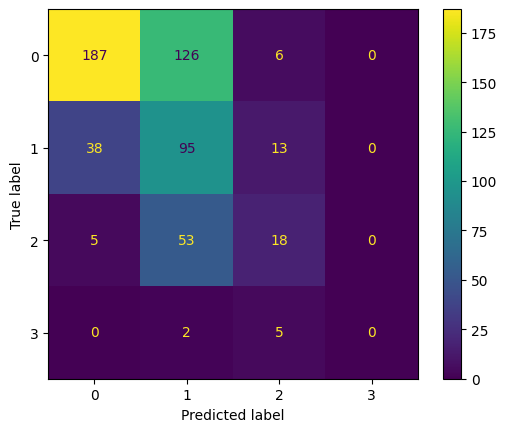

F1 score across fold: 0.5588251026121347
Cohen kappa score across fold: 0.4664196827206232


,Feature,Importance,Value_1
54,SDS-SDS_Total_Raw,40.0,40
18,FGC-FGC_CU,32.0,32
11,Physical-HeartRate,29.0,29
12,Physical-Systolic_BP,29.0,29
120,DEE_Weight,27.0,27
4,CGAS-CGAS_Score,26.0,26
6,Physical-BMI,26.0,26
7,Physical-Height,26.0,26
52,PAQ_C-PAQ_C_Total,24.0,24
112,BMI_Internet_Hours,20.0,20


fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.464005	valid's QWK: 0.409865
[50]	train's QWK: 0.532773	valid's QWK: 0.403678
[75]	train's QWK: 0.576475	valid's QWK: 0.426097
[100]	train's QWK: 0.604311	valid's QWK: 0.419118
[125]	train's QWK: 0.631165	valid's QWK: 0.416522
Early stopping, best iteration is:
[72]	train's QWK: 0.573443	valid's QWK: 0.436058
Evaluated only: QWK


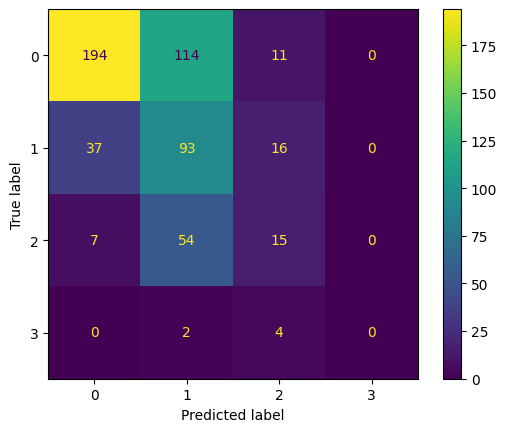

F1 score across fold: 0.5617851221239932
Cohen kappa score across fold: 0.4360576939328076


,Feature,Importance,Value_1,Value_2
0,SDS-SDS_Total_Raw,34.0,40,28
1,FGC-FGC_CU,21.5,32,11
2,Physical-HeartRate,18.0,29,7
3,Physical-Systolic_BP,17.5,29,6
5,CGAS-CGAS_Score,16.5,26,7
4,DEE_Weight,16.0,27,5
7,Physical-Height,16.0,26,6
16,SDS-SDS_Total_T,15.0,18,12
6,Physical-BMI,14.0,26,2
20,Basic_Demos-Sex,13.5,16,11


fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.472085	valid's QWK: 0.383732
[50]	train's QWK: 0.531386	valid's QWK: 0.393461
[75]	train's QWK: 0.566098	valid's QWK: 0.409295
[100]	train's QWK: 0.599713	valid's QWK: 0.412665
[125]	train's QWK: 0.631954	valid's QWK: 0.394885
[150]	train's QWK: 0.659431	valid's QWK: 0.393916
Early stopping, best iteration is:
[89]	train's QWK: 0.582607	valid's QWK: 0.419544
Evaluated only: QWK


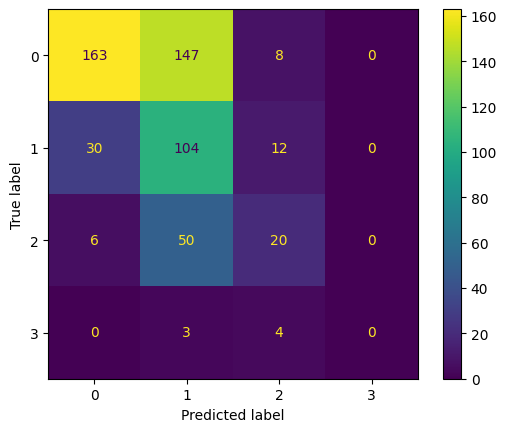

F1 score across fold: 0.5362635338565945
Cohen kappa score across fold: 0.4195444852000342


,Feature,Importance,Value_1,Value_2,Value_3
0,SDS-SDS_Total_Raw,31.333333,40,28,26
1,FGC-FGC_CU,19.000000,32,11,14
2,Physical-HeartRate,16.666667,29,7,14
6,Physical-Height,15.333333,26,6,14
4,CGAS-CGAS_Score,15.000000,26,7,12
7,SDS-SDS_Total_T,14.000000,18,12,12
3,Physical-Systolic_BP,12.666667,29,6,3
5,DEE_Weight,12.333333,27,5,5
9,Basic_Demos-Sex,12.333333,16,11,10
15,PreInt_EduHx-computerinternet_hoursday,11.333333,13,10,11


fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.495389	valid's QWK: 0.382196
[50]	train's QWK: 0.55615	valid's QWK: 0.363107
[75]	train's QWK: 0.595668	valid's QWK: 0.368133
[100]	train's QWK: 0.618686	valid's QWK: 0.369232
Early stopping, best iteration is:
[27]	train's QWK: 0.498102	valid's QWK: 0.388477
Evaluated only: QWK


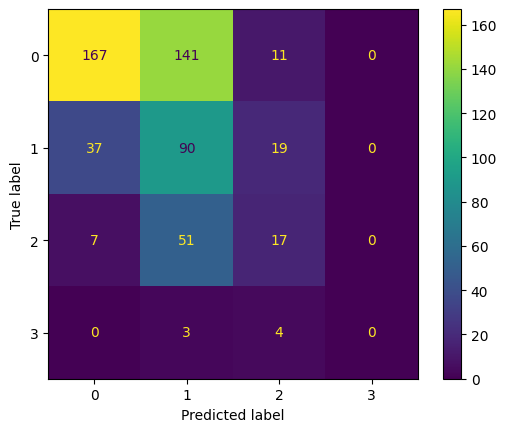

F1 score across fold: 0.5159831112899034
Cohen kappa score across fold: 0.3884770485912401


,Feature,Importance,Value_1,Value_2,Value_3,Value_4
0,SDS-SDS_Total_Raw,27.50,40,28,26,16
1,FGC-FGC_CU,15.50,32,11,14,5
3,Physical-Height,13.25,26,6,14,7
2,Physical-HeartRate,12.75,29,7,14,1
5,SDS-SDS_Total_T,12.25,18,12,12,7
4,CGAS-CGAS_Score,11.75,26,7,12,2
8,Basic_Demos-Sex,11.00,16,11,10,7
14,Internet_Hours_Age,10.50,14,11,7,10
6,Physical-Systolic_BP,10.25,29,6,3,3
9,PreInt_EduHx-computerinternet_hoursday,10.25,13,10,11,7


fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.483621	valid's QWK: 0.382426
[50]	train's QWK: 0.546373	valid's QWK: 0.443858
[75]	train's QWK: 0.58489	valid's QWK: 0.428755
[100]	train's QWK: 0.617123	valid's QWK: 0.412673
[125]	train's QWK: 0.655086	valid's QWK: 0.422917
[150]	train's QWK: 0.690171	valid's QWK: 0.444482
[175]	train's QWK: 0.70833	valid's QWK: 0.428224
[200]	train's QWK: 0.73541	valid's QWK: 0.430095
Early stopping, best iteration is:
[134]	train's QWK: 0.668592	valid's QWK: 0.449174
Evaluated only: QWK


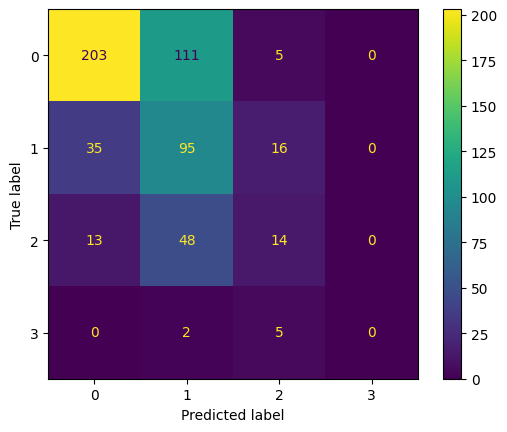

F1 score across fold: 0.5749239278779609
Cohen kappa score across fold: 0.4491740939611062


,Feature,Importance,Value_1,Value_2,Value_3,Value_4,Value_5
0,SDS-SDS_Total_Raw,27.6,40,28,26,16,28
1,FGC-FGC_CU,15.4,32,11,14,5,15
3,Physical-HeartRate,13.4,29,7,14,1,16
8,Physical-Systolic_BP,12.8,29,6,3,3,23
5,CGAS-CGAS_Score,12.6,26,7,12,2,16
2,Physical-Height,12.4,26,6,14,7,9
4,SDS-SDS_Total_T,12.4,18,12,12,7,13
6,Basic_Demos-Sex,11.6,16,11,10,7,14
10,FGC-FGC_PU,11.4,20,6,7,5,19
7,Internet_Hours_Age,11.4,14,11,7,10,15


Mean F1 score across 5 folds: 0.5495561595521173
Mean Cohen kappa score across 5 folds: 0.4319346008811623


In [28]:
n_splits = 5
n_estimators = 500

#stratified K fold based on classes
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

f1_scores = []
kappa_scores = []
models = []
predictions = []
feature_importance_df = None

# Early stopping call back to avoid overfitting
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]

y_true =  y

i=1
for train_index, test_index in skf.split(X, y):
   
    print('fold',i)

    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]   
   
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_true[test_index]
  
    model = lgb.LGBMRegressor( 
                objective = qwk_obj if custom_objective_on else None,
                metrics = 'None',
                learning_rate = params["learning_rate"],
                max_depth = round(params["max_depth"]),
                num_leaves = 2 ^(round(params["max_depth"]) - 1),
                colsample_bytree=params["colsample_bytree"],
                reg_alpha = params["reg_alpha"],
                reg_lambda = params["reg_lambda"],
                n_estimators=n_estimators,
                random_state=42,
                #extra_trees=True,
                #class_weight='balanced',
                verbosity = - 1)
    

    
    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric= quadratic_weighted_kappa if custom_metric else None,
                                  callbacks=callbacks,)
    
    #saving all models for inference
    models.append(predictor)
    predictions_fold = predictor.predict(X_test_fold)
    #predictions_fold = predictions_fold + a
    training_predictions [test_index]=predictions_fold
    predictions_fold = predictions_fold.clip(y_min, y_max).round()
    predictions.append(predictions_fold)
    training_clipped_predictions [test_index]=predictions_fold
    
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
        
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(0,4)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(0,4)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    
    # Capturing the importance of each feature through the folds    
    fold_feature_imp = pd.DataFrame({'Feature':features, f'Value_{i}':predictor.feature_importances_}) 
    feature_importance_df = fold_feature_imp if feature_importance_df is None else feature_importance_df.merge(fold_feature_imp, on = ['Feature'] )      
    value_cols = [ c for c in feature_importance_df.columns if c.startswith('Value_')]
    feature_importance_df["Importance"] = np.mean(feature_importance_df[value_cols], axis = 1)
    feature_importance_df = feature_importance_df.sort_values(by = ["Importance"], ascending = False)
    feature_importance_df = feature_importance_df[["Feature", "Importance"] + [ c for c in feature_importance_df.columns if c.startswith('Value_')]]
    display(feature_importance_df.head(10))       
    
    i+=1

mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

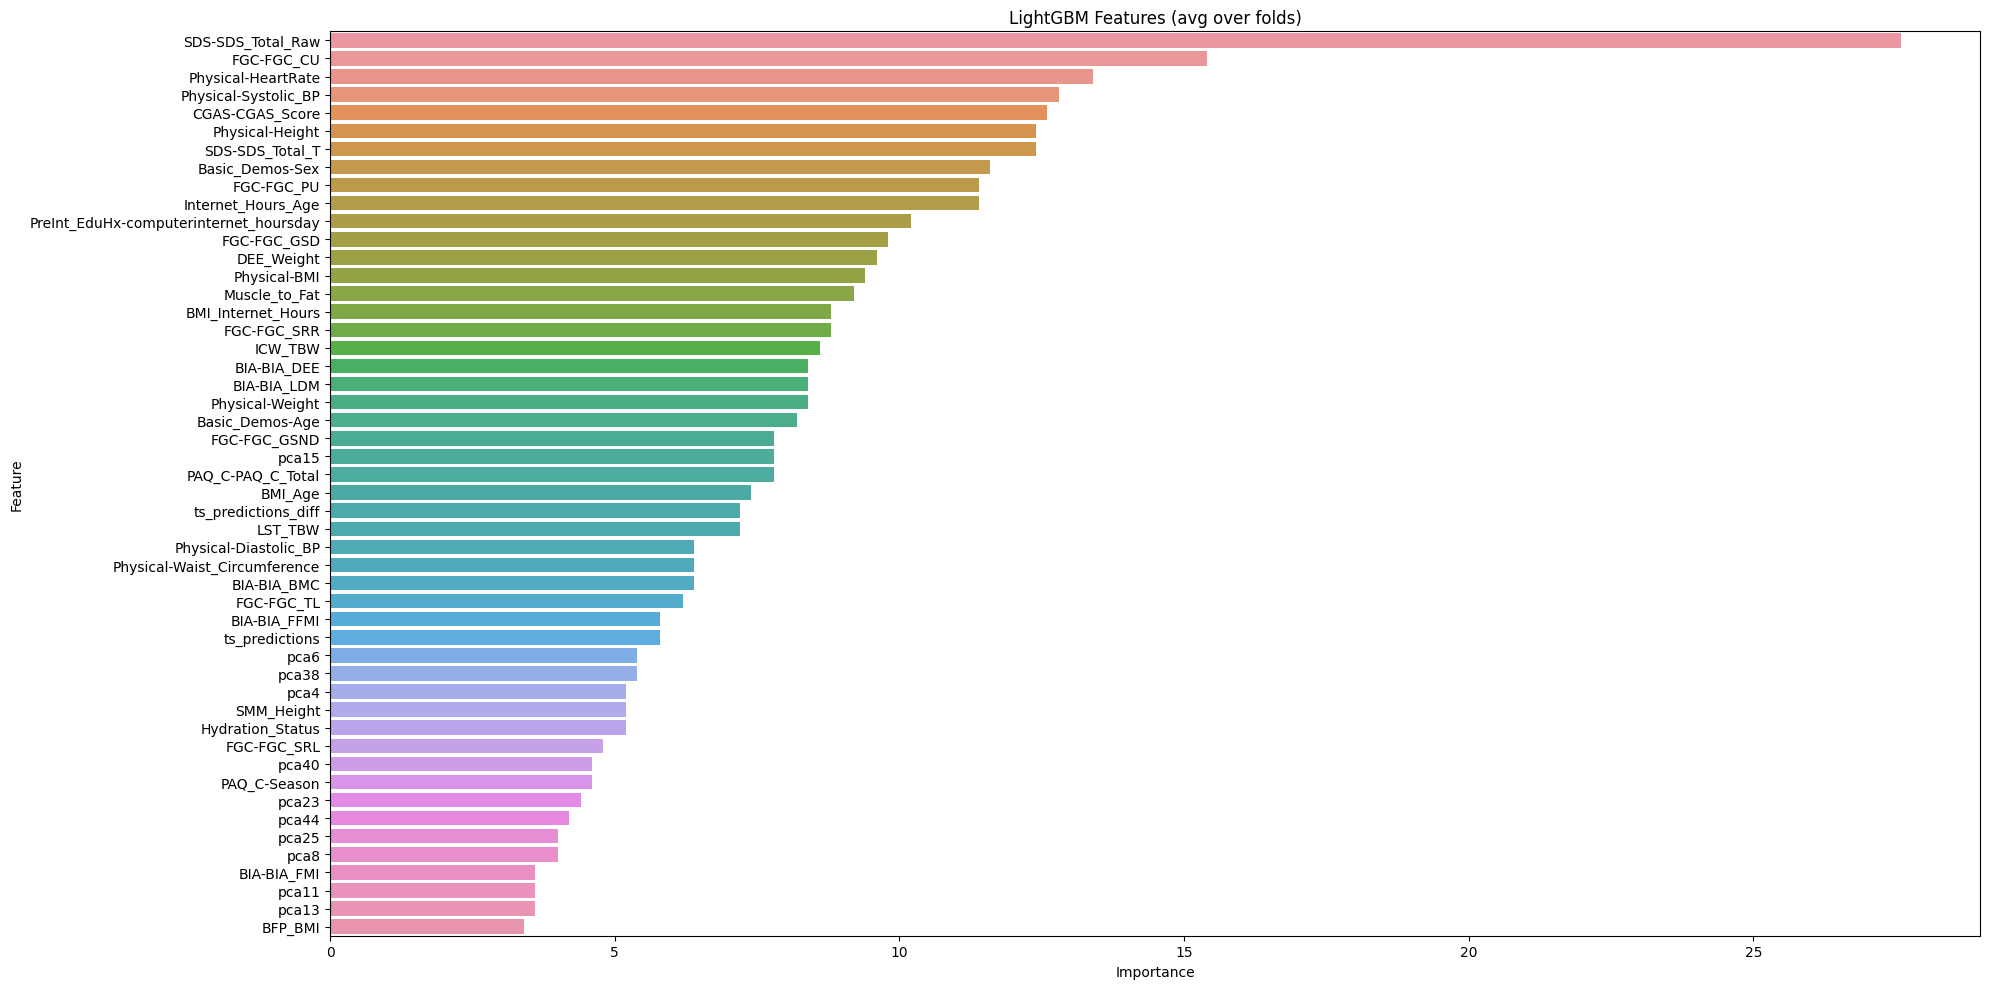

In [29]:
feature_importance_df.to_csv("/kaggle/working/feature_importance.csv")    
plt.figure(figsize=(20,10))
#sns.set(font_scale = 1)
sns.barplot(x="Importance", y="Feature", data= feature_importance_df[0:50])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

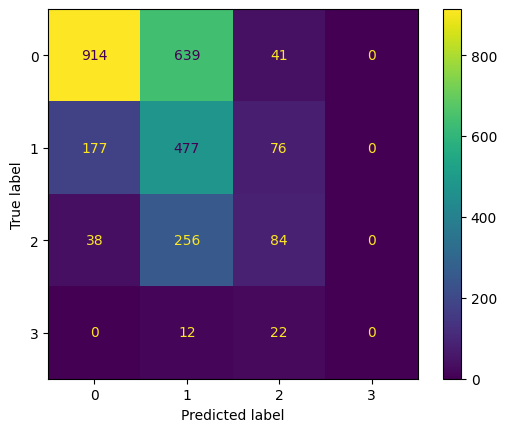

In [30]:
cm = confusion_matrix(y , training_clipped_predictions, labels=[x for x in range(0,4)])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(0,4)])
disp.plot()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

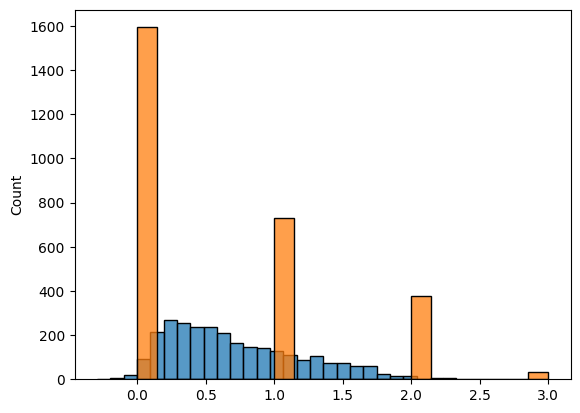

In [31]:
sns.histplot(training_predictions)
sns.histplot(y)

# XGBoost

In [32]:
import xgboost
from xgboost import XGBRegressor
def xgb_cv_evaluator(learning_rate, max_depth, colsample_bytree,reg_alpha, reg_lambda):

    i = 0
    f1_scores = []
    kappa_scores = []
    for train_index, test_index in skf.split(numeric_X, y):

        print('fold',i+1, X.shape, y.shape)
        X_train_fold, X_test_fold = numeric_X.iloc[train_index], numeric_X.iloc[test_index]
        
        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y[test_index]
        xgb_callbacks = [
            xgboost.callback.EvaluationMonitor(period=100),
            #xgboost.callback.EarlyStopping(50, metric_name="QWK", maximize=True, save_best=True)
        ]
        xgb_model = XGBRegressor(
                    #objective = qwk_obj if custom_objective_on else 'regression',
                    #metrics = 'None',
                    learning_rate = learning_rate,
                    max_depth = round(max_depth),
                    #num_leaves = 2 ^( round(max_depth) - 1 ),
                    colsample_bytree=colsample_bytree,
                    reg_alpha =reg_alpha,
                    reg_lambda = reg_lambda,
                    n_estimators=n_estimators,
                    random_state=42,
                    enable_categorical = True,
                    tree_method = "hist", 
                    device = "cuda",
                    callbacks=xgb_callbacks,
                    #eval_metric=quadratic_weighted_kappa_xgb,
                    #verbose_eval=False
                    early_stopping_rounds = 50
                    

        )


        predictor = xgb_model.fit(X_train_fold,
                                      y_train_fold,
                                      eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                      #eval_set= (X_test_fold, y_test_fold),
                                      verbose = 0,
                                      #eval_metric=quadratic_weighted_kappa_xgb
                                 )
        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold
        predictions_fold = predictions_fold.clip(y_min, y_max).round()
        #f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)

        kappa_fold = quadratic_kappa(y_test_fold_int, predictions_fold)
        kappa_scores.append(kappa_fold)
        #print(f' fold {i+1} = F1 score across fold: {f1_fold}', f'Cohen kappa score across fold: {kappa_fold}')
        print( f'Cohen kappa score across fold: {kappa_fold}')
        i+=1

    #mean_f1_score = np.mean(f1_scores)
    mean_kappa_score = np.mean(kappa_scores)


    #print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
    print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')
    return mean_kappa_score

In [33]:
          
if bayesian_optimization_xgb:
    n_splits = 5
    n_estimators = 1000
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    max_params = bayesian_parameter_optimization( init_rounds = bayesian_init_rounds, opt_rounds = bayesian_opt_rounds, parameter_bounds = xgb_pbounds, evaluator =xgb_cv_evaluator)
    XGB_Params = max_params['params']
    print("new XBG bayesian params:", XGB_Params)

In [34]:
XGB_Params

{'colsample_bytree': 0.6053939548634096,
 'learning_rate': 0.017135359956360424,
 'max_depth': 5.975773894779193,
 'reg_alpha': 9.4893665171608,
 'reg_lambda': 9.656664010414849}

fold 1
[0]	validation_0-rmse:0.76724	validation_1-rmse:0.77041


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:47:49] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.61385	validation_1-rmse:0.68239
[200]	validation_0-rmse:0.55833	validation_1-rmse:0.66918
[300]	validation_0-rmse:0.52147	validation_1-rmse:0.66724
[400]	validation_0-rmse:0.49397	validation_1-rmse:0.66574
[459]	validation_0-rmse:0.47956	validation_1-rmse:0.66611


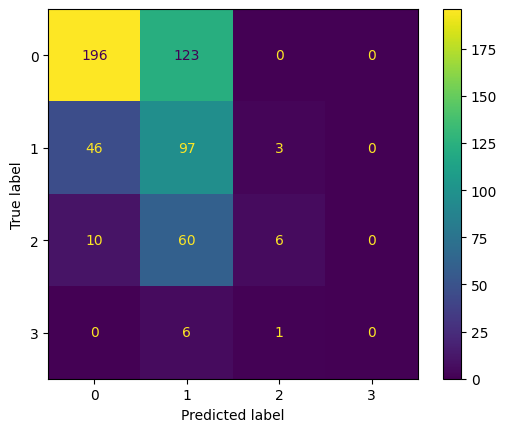

F1 score across fold: 0.5386272165403656
Cohen kappa score across fold: 0.3847677513003508


,Feature,Importance,Value_1
0,Basic_Demos-Age,0.083073,0.083073
101,Internet_Hours_Age,0.066854,0.066854
47,PreInt_EduHx-computerinternet_hoursday,0.028874,0.028874
45,SDS-SDS_Total_Raw,0.021265,0.021265
4,Physical-Height,0.020093,0.020093
46,SDS-SDS_Total_T,0.015191,0.015191
51,pca1,0.013288,0.013288
102,BMI_Internet_Hours,0.010871,0.010871
5,Physical-Weight,0.010069,0.010069
39,BIA-BIA_LDM,0.009706,0.009706


fold 2
[0]	validation_0-rmse:0.76884	validation_1-rmse:0.76395


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:48:06] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.61832	validation_1-rmse:0.66584
[200]	validation_0-rmse:0.56240	validation_1-rmse:0.65641
[278]	validation_0-rmse:0.53220	validation_1-rmse:0.65753


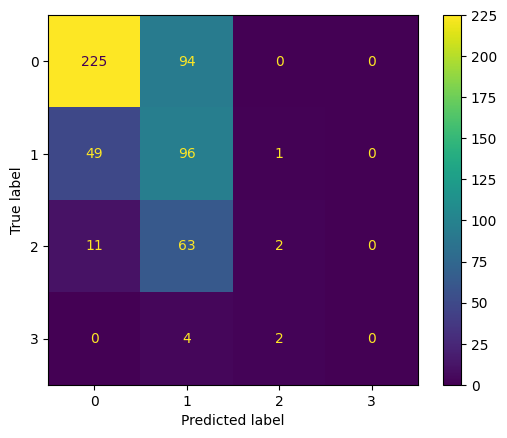

F1 score across fold: 0.5685136416613294
Cohen kappa score across fold: 0.43069994544673706


,Feature,Importance,Value_1,Value_2
0,Basic_Demos-Age,0.084476,0.083073,0.085879
1,Internet_Hours_Age,0.072206,0.066854,0.077559
2,PreInt_EduHx-computerinternet_hoursday,0.026411,0.028874,0.023948
4,Physical-Height,0.023504,0.020093,0.026916
3,SDS-SDS_Total_Raw,0.021267,0.021265,0.021269
5,SDS-SDS_Total_T,0.014293,0.015191,0.013394
21,PAQ_A-Season_Summer,0.011791,0.007895,0.015686
11,Basic_Demos-Sex,0.010679,0.009238,0.012120
10,BMI_Age,0.010430,0.009688,0.011172
6,pca1,0.010321,0.013288,0.007353


fold 3
[0]	validation_0-rmse:0.76720	validation_1-rmse:0.77051


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:48:16] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.61509	validation_1-rmse:0.67565
[200]	validation_0-rmse:0.55823	validation_1-rmse:0.66560
[259]	validation_0-rmse:0.53461	validation_1-rmse:0.66655


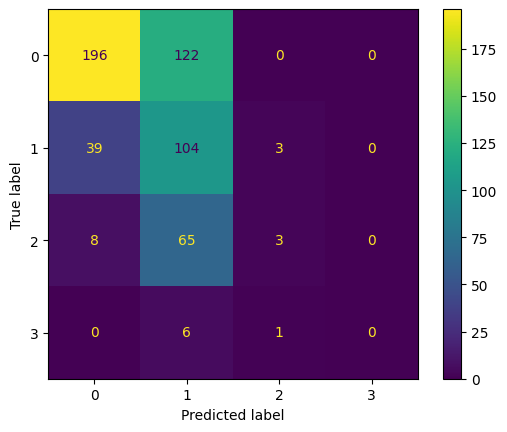

F1 score across fold: 0.5415867907266623
Cohen kappa score across fold: 0.39822593549975394


,Feature,Importance,Value_1,Value_2,Value_3
0,Basic_Demos-Age,0.091208,0.083073,0.085879,0.104672
1,Internet_Hours_Age,0.064856,0.066854,0.077559,0.050156
2,PreInt_EduHx-computerinternet_hoursday,0.027271,0.028874,0.023948,0.028989
3,Physical-Height,0.022891,0.020093,0.026916,0.021663
4,SDS-SDS_Total_Raw,0.022620,0.021265,0.021269,0.025326
5,SDS-SDS_Total_T,0.015543,0.015191,0.013394,0.018044
7,Basic_Demos-Sex,0.011250,0.009238,0.012120,0.012392
6,PAQ_A-Season_Summer,0.011117,0.007895,0.015686,0.009771
10,Physical-Weight,0.009987,0.010069,0.010525,0.009366
8,BMI_Age,0.009907,0.009688,0.011172,0.008861


fold 4
[0]	validation_0-rmse:0.76765	validation_1-rmse:0.76857


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:48:26] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.61031	validation_1-rmse:0.69187
[200]	validation_0-rmse:0.55247	validation_1-rmse:0.68956
[221]	validation_0-rmse:0.54410	validation_1-rmse:0.68994


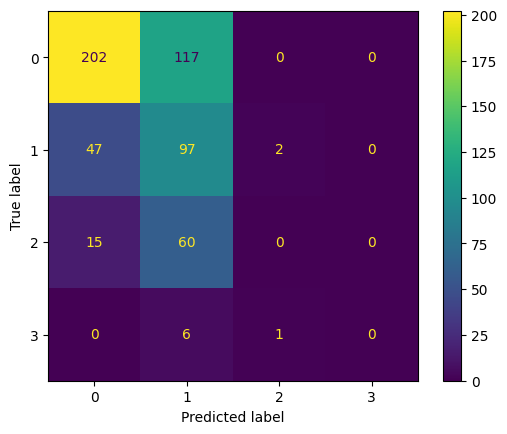

F1 score across fold: 0.5256761730975923
Cohen kappa score across fold: 0.3376099492646687


,Feature,Importance,Value_1,Value_2,Value_3,Value_4
0,Basic_Demos-Age,0.093817,0.083073,0.085879,0.104672,0.101643
1,Internet_Hours_Age,0.063545,0.066854,0.077559,0.050156,0.059613
2,PreInt_EduHx-computerinternet_hoursday,0.025666,0.028874,0.023948,0.028989,0.020853
3,Physical-Height,0.024202,0.020093,0.026916,0.021663,0.028135
4,SDS-SDS_Total_Raw,0.023840,0.021265,0.021269,0.025326,0.027497
5,SDS-SDS_Total_T,0.015679,0.015191,0.013394,0.018044,0.016087
6,Basic_Demos-Sex,0.011296,0.009238,0.012120,0.012392,0.011434
7,PAQ_A-Season_Summer,0.010214,0.007895,0.015686,0.009771,0.007503
10,BIA-BIA_LDM,0.009972,0.009706,0.010384,0.008940,0.010860
11,BMI_Internet_Hours,0.009623,0.010871,0.008279,0.008889,0.010452


fold 5
[0]	validation_0-rmse:0.76752	validation_1-rmse:0.76886


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:48:35] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.61244	validation_1-rmse:0.69125
[200]	validation_0-rmse:0.55498	validation_1-rmse:0.68361
[300]	validation_0-rmse:0.51931	validation_1-rmse:0.68281
[308]	validation_0-rmse:0.51699	validation_1-rmse:0.68283


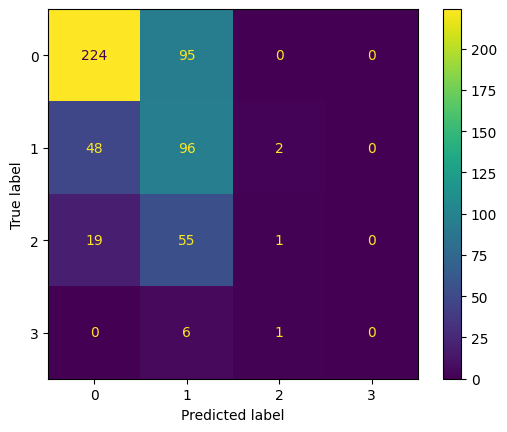

F1 score across fold: 0.5605353970646253
Cohen kappa score across fold: 0.3671779813128654


,Feature,Importance,Value_1,Value_2,Value_3,Value_4,Value_5
0,Basic_Demos-Age,0.086895,0.083073,0.085879,0.104672,0.101643,0.059205
1,Internet_Hours_Age,0.070860,0.066854,0.077559,0.050156,0.059613,0.100116
2,PreInt_EduHx-computerinternet_hoursday,0.027410,0.028874,0.023948,0.028989,0.020853,0.034384
3,Physical-Height,0.026055,0.020093,0.026916,0.021663,0.028135,0.033469
4,SDS-SDS_Total_Raw,0.023139,0.021265,0.021269,0.025326,0.027497,0.020337
5,SDS-SDS_Total_T,0.015256,0.015191,0.013394,0.018044,0.016087,0.013563
7,PAQ_A-Season_Summer,0.011857,0.007895,0.015686,0.009771,0.007503,0.018431
6,Basic_Demos-Sex,0.011398,0.009238,0.012120,0.012392,0.011434,0.011806
9,BMI_Internet_Hours,0.009844,0.010871,0.008279,0.008889,0.010452,0.010732
10,BMI_Age,0.009817,0.009688,0.011172,0.008861,0.008725,0.010639


Mean F1 score across 5 folds: 0.5482720016851161
Mean Cohen kappa score across 5 folds: 0.3836963125648752


In [35]:


xgb_training_predictions = np.zeros((df_train.shape[0],))
xgb_training_clipped_predictions = np.zeros((df_train.shape[0],))

#xgboost_on = True
if xgboost_on:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    #f1_scores = []
    kappa_scores = []
    xgb_models = []
    xgb_predictions = []
    xgb_feature_importance_df = None
    # Early stopping call back to avoid overfitting
    y_true =  y

    i=1
    for train_index, test_index in skf.split(numeric_X, y):

        print('fold',i)

        X_train_fold, X_test_fold = numeric_X.iloc[train_index], numeric_X.iloc[test_index]   

        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_true[test_index]
        xgb_callbacks = [
            xgboost.callback.EvaluationMonitor(period=100),
            #xgboost.callback.EarlyStopping(75, metric_name="QWK", maximize=True, save_best=True)
        ]
        xgb_model = XGBRegressor(
                                learning_rate = XGB_Params["learning_rate"],
                                max_depth = round(XGB_Params["max_depth"]),
                                colsample_bytree = XGB_Params["colsample_bytree"],
                                reg_alpha = XGB_Params["reg_alpha"],
                                reg_lambda = XGB_Params["reg_lambda"],
                                enable_categorical = True, 
                                n_estimators=n_estimators,
                                 #device = 'cpu',
                                 #objective = qwk_obj,
                                #metrics = 'None',
                                tree_method = "hist", 
                                device = "cuda",
                                callbacks=xgb_callbacks,
                                #eval_metric=quadratic_weighted_kappa_xgb,
                                #verbose_eval=False
                                early_stopping_rounds = 50
                                )
        

        predictor = xgb_model.fit(X_train_fold,
                                      y_train_fold,
                                      eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                      #eval_metric=quadratic_weighted_kappa_xgb,
                                      #callbacks=xgb_callbacks,
                                      verbose = 0                              
                                 )

        #saving all models for inference
        xgb_models.append(predictor)
        predictions_fold = predictor.predict(X_test_fold)
        #predictions_fold = predictions_fold + a
        xgb_training_predictions [test_index]=predictions_fold
        predictions_fold = predictions_fold.clip(y_min, y_max).round()
        xgb_predictions.append(predictions_fold)
        xgb_training_clipped_predictions [test_index]=predictions_fold

        f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)

        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(0,4)])

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(0,4)])
        disp.plot()
        plt.show()
        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')

        # Capturing the importance of each feature through the folds    
        fold_feature_imp = pd.DataFrame({'Feature':numeric_X.columns, f'Value_{i}':predictor.feature_importances_}) 
        xgb_feature_importance_df = fold_feature_imp if xgb_feature_importance_df is None else xgb_feature_importance_df.merge(fold_feature_imp, on = ['Feature'] )      
        value_cols = [ c for c in xgb_feature_importance_df.columns if c.startswith('Value_')]
        xgb_feature_importance_df["Importance"] = np.mean(xgb_feature_importance_df[value_cols], axis = 1)
        xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by = ["Importance"], ascending = False)
        xgb_feature_importance_df = xgb_feature_importance_df[["Feature", "Importance"] + [ c for c in xgb_feature_importance_df.columns if c.startswith('Value_')]]
        display(xgb_feature_importance_df.head(10))       

        i+=1

    mean_f1_score = np.mean(f1_scores)
    mean_kappa_score = np.mean(kappa_scores)

    print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
    print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

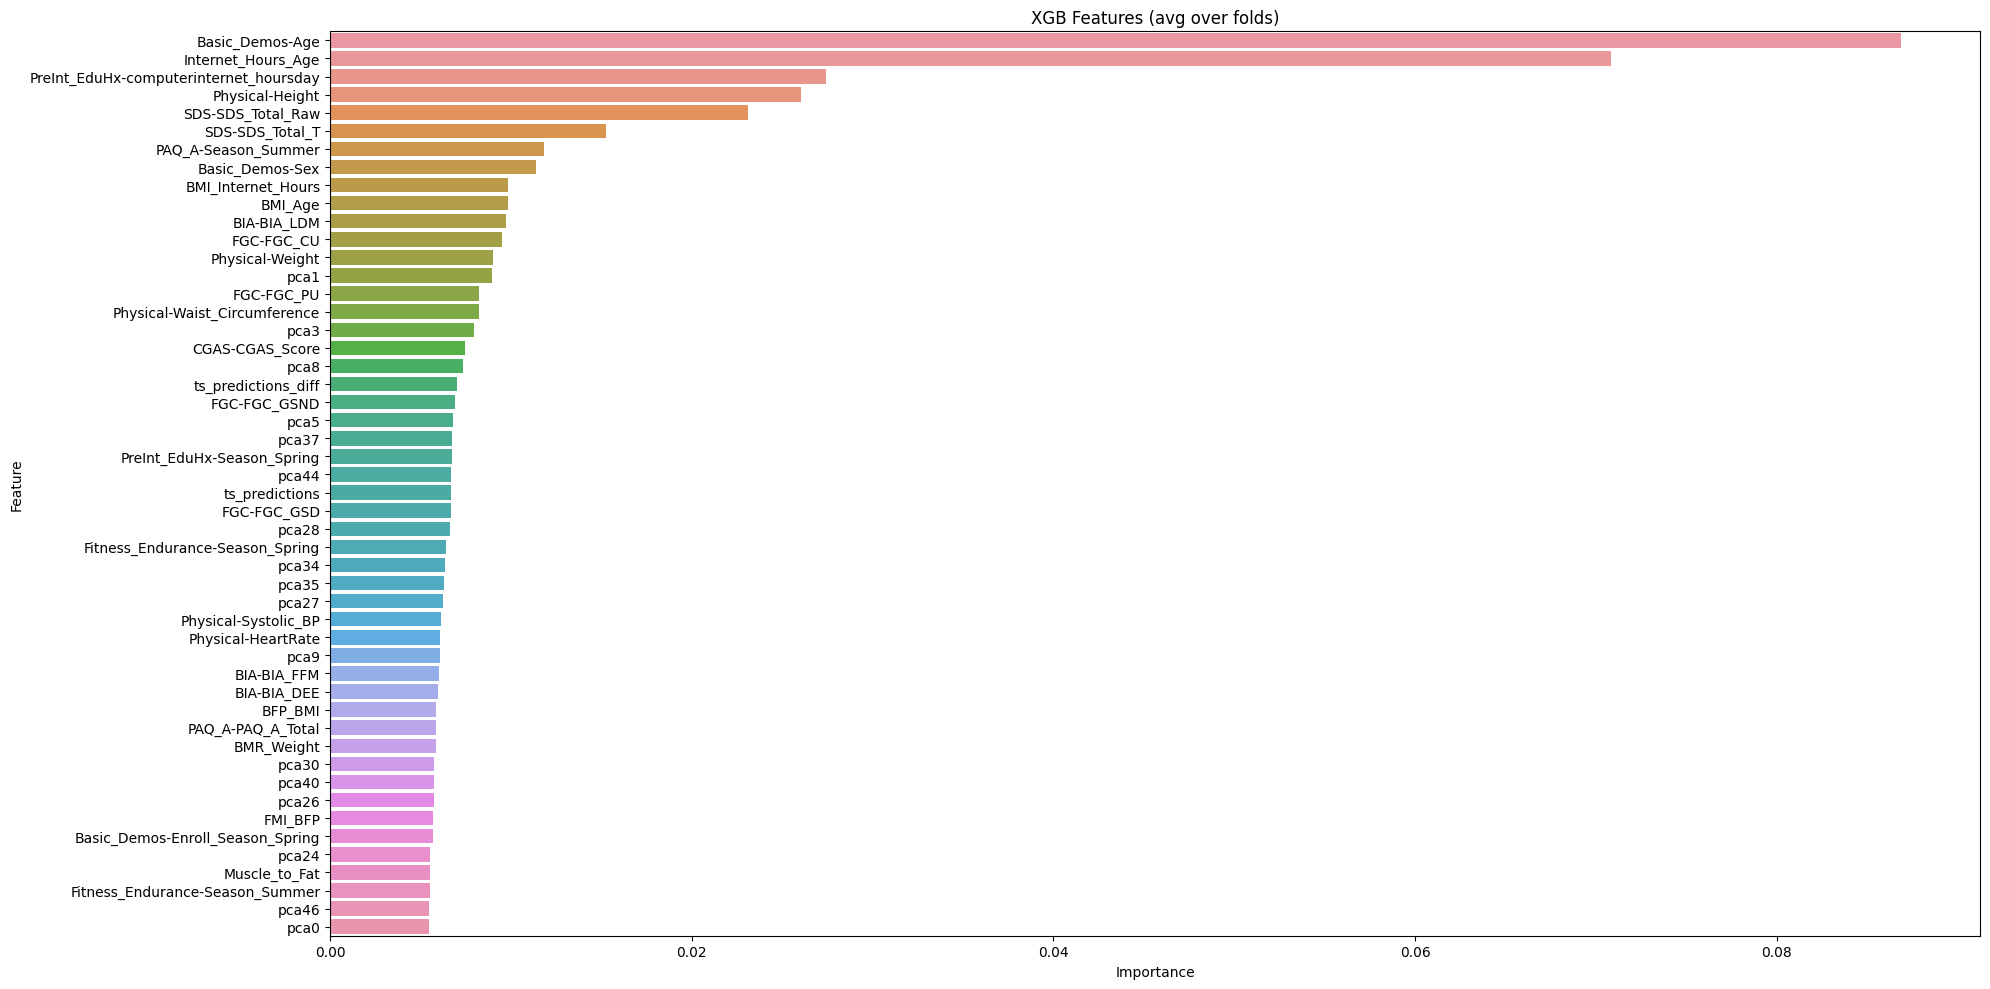

In [36]:
if xgboost_on:
    xgb_feature_importance_df.to_csv("/kaggle/working/xgb_feature_importance.csv")    
    plt.figure(figsize=(20,10))
    #sns.set(font_scale = 1)
    sns.barplot(x="Importance", y="Feature", data= xgb_feature_importance_df[0:50])
    plt.title('XGB Features (avg over folds)')
    plt.tight_layout()
    plt.show()

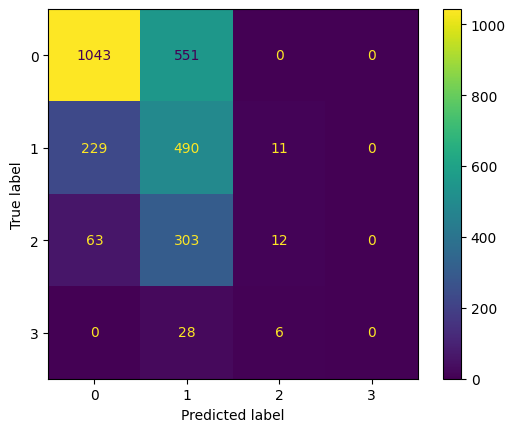

In [37]:
if xgboost_on:
    cm = confusion_matrix(y , xgb_training_clipped_predictions, labels=[x for x in range(0,4)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(0,4)])
    disp.plot()

# Random Forest Regressor

In [38]:
from sklearn.ensemble import RandomForestRegressor



def rf_cv_evaluator( max_depth, n_estimators, max_samples ,min_samples_split, min_samples_leaf):

    i = 0
    kappa_scores = []
    for train_index, test_index in skf.split(numeric_X, y):

        #print('fold',i+1, X.shape, y.shape)
        X_train_fold, X_test_fold = numeric_X.iloc[train_index], numeric_X.iloc[test_index]
        
        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y[test_index]
        model =  RandomForestRegressor(
                    max_depth = round(max_depth),
                    max_samples =max_samples ,
                    min_samples_split =min_samples_split,
                    min_samples_leaf = min_samples_leaf,
                    n_estimators=round(n_estimators),
                    random_state=42,
        )


        predictor = model.fit(X_train_fold,
                                      y_train_fold,
                                 )
        predictions_fold = predictor.predict(X_test_fold)
        #print( predictions_fold[:20])

        predictions_fold = predictions_fold.clip(y_min, y_max).round()
        #print(np.unique(predictions_fold), predictions_fold[:20])
        #print(y_test_fold_int[:20])

        kappa_fold = quadratic_kappa(y_test_fold_int, predictions_fold)
        kappa_scores.append(kappa_fold)
        #print( f'Cohen kappa score across fold: {kappa_fold}')
        i+=1

    mean_kappa_score = np.mean(kappa_scores)


    print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')
    return mean_kappa_score

In [39]:
 

numeric_X.fillna(0, inplace = True)
if bayesian_optimization_rf:
    n_splits = 5
    n_estimators = 1000
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    #max_params = bayesian_parameter_optimization( init_rounds = bayesian_init_rounds, opt_rounds = bayesian_opt_rounds, parameter_bounds = rf_pbounds, evaluator =rf_cv_evaluator)
    max_params = bayesian_parameter_optimization( init_rounds = 20, opt_rounds = 80, parameter_bounds = rf_pbounds, evaluator =rf_cv_evaluator)

    rf_params = max_params['params']
    print("new RF bayesian params:", rf_params)

Mean Cohen kappa score across 5 folds: 0.0
Iteration: 0 - Kappa: 0.0 - {'max_depth': 13.745401188473625, 'max_samples': 0.951207163345817, 'min_samples_leaf': 0.727354062975177, 'min_samples_split': 0.5966853145130959, 'n_estimators': 32.48149123539492}
Mean Cohen kappa score across 5 folds: 0.0
Iteration: 1 - Kappa: 0.0 - {'max_depth': 11.559945203362027, 'max_samples': 0.06750277604651747, 'min_samples_leaf': 0.8588526228594364, 'min_samples_split': 0.5990927115083446, 'n_estimators': 76.64580622368364}
Mean Cohen kappa score across 5 folds: 0.0
Iteration: 2 - Kappa: 0.0 - {'max_depth': 10.205844942958024, 'max_samples': 0.9702107536403743, 'min_samples_leaf': 0.8257937879844133, 'min_samples_split': 0.21809232846471063, 'n_estimators': 34.54599737656805}
Mean Cohen kappa score across 5 folds: 0.0
Iteration: 3 - Kappa: 0.0 - {'max_depth': 11.834045098534338, 'max_samples': 0.31119982052994233, 'min_samples_leaf': 0.5242613029995931, 'min_samples_split': 0.43330611826927345, 'n_estima

In [40]:
rf_params

{'max_depth': 16.358239880091453,
 'max_samples': 0.7688067432350616,
 'min_samples_leaf': 0.01,
 'min_samples_split': 0.01,
 'n_estimators': 32.79245268456169}

fold 1


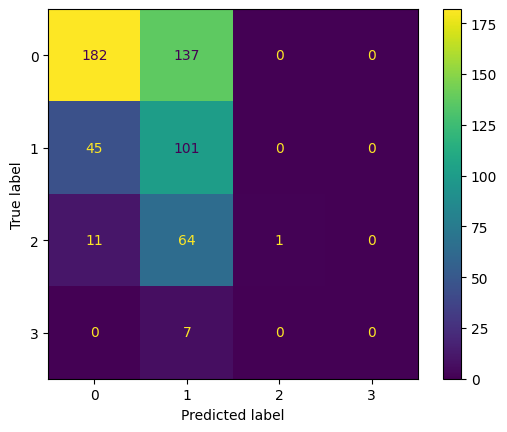

Cohen kappa score across fold: 0.3145419502025725


,Feature,Importance,Value_1
101,Internet_Hours_Age,0.201809,0.201809
0,Basic_Demos-Age,0.193894,0.193894
45,SDS-SDS_Total_Raw,0.100349,0.100349
46,SDS-SDS_Total_T,0.051010,0.051010
100,BMI_Age,0.036916,0.036916
5,Physical-Weight,0.030099,0.030099
102,BMI_Internet_Hours,0.026837,0.026837
9,Physical-Systolic_BP,0.019075,0.019075
4,Physical-Height,0.018338,0.018338
44,PAQ_C-PAQ_C_Total,0.014308,0.014308


fold 2


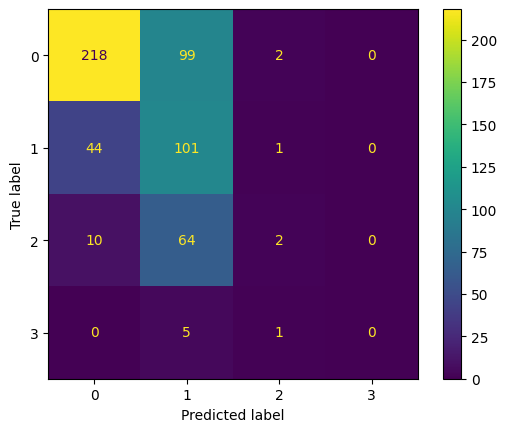

Cohen kappa score across fold: 0.4135512662220795


,Feature,Importance,Value_1,Value_2
0,Internet_Hours_Age,0.222174,0.201809,0.242538
1,Basic_Demos-Age,0.151323,0.193894,0.108753
2,SDS-SDS_Total_Raw,0.091330,0.100349,0.082312
3,SDS-SDS_Total_T,0.057784,0.051010,0.064557
8,Physical-Height,0.039848,0.018338,0.061359
4,BMI_Age,0.034562,0.036916,0.032208
5,Physical-Weight,0.025943,0.030099,0.021786
6,BMI_Internet_Hours,0.022063,0.026837,0.017289
7,Physical-Systolic_BP,0.018743,0.019075,0.018411
16,CGAS-CGAS_Score,0.014468,0.011425,0.017511


fold 3


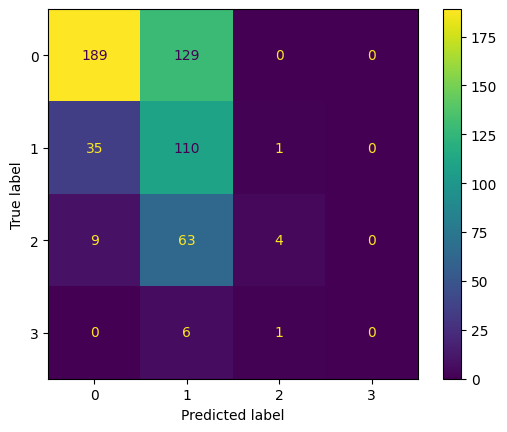

Cohen kappa score across fold: 0.3874057855883436


,Feature,Importance,Value_1,Value_2,Value_3
0,Internet_Hours_Age,0.191073,0.201809,0.242538,0.128873
1,Basic_Demos-Age,0.184493,0.193894,0.108753,0.250832
2,SDS-SDS_Total_Raw,0.075469,0.100349,0.082312,0.043746
3,SDS-SDS_Total_T,0.073868,0.051010,0.064557,0.106036
4,Physical-Height,0.041960,0.018338,0.061359,0.046182
5,BMI_Age,0.033464,0.036916,0.032208,0.031267
6,Physical-Weight,0.024751,0.030099,0.021786,0.022369
7,BMI_Internet_Hours,0.024638,0.026837,0.017289,0.029789
8,Physical-Systolic_BP,0.017176,0.019075,0.018411,0.014041
9,CGAS-CGAS_Score,0.015523,0.011425,0.017511,0.017632


fold 4


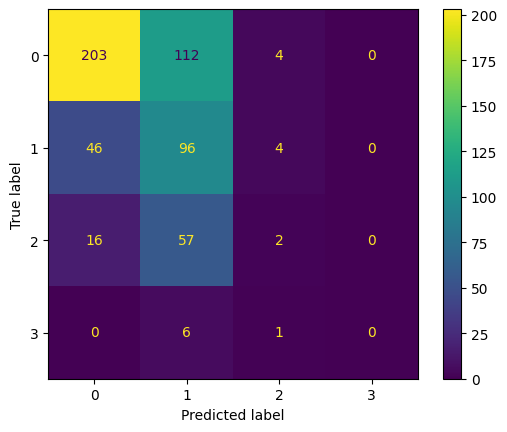

Cohen kappa score across fold: 0.331129276963837


,Feature,Importance,Value_1,Value_2,Value_3,Value_4
1,Basic_Demos-Age,0.197772,0.193894,0.108753,0.250832,0.237609
0,Internet_Hours_Age,0.193167,0.201809,0.242538,0.128873,0.199446
3,SDS-SDS_Total_T,0.074127,0.051010,0.064557,0.106036,0.074903
2,SDS-SDS_Total_Raw,0.072583,0.100349,0.082312,0.043746,0.063926
4,Physical-Height,0.036742,0.018338,0.061359,0.046182,0.021091
5,BMI_Age,0.028826,0.036916,0.032208,0.031267,0.014913
7,BMI_Internet_Hours,0.024062,0.026837,0.017289,0.029789,0.022332
6,Physical-Weight,0.023777,0.030099,0.021786,0.022369,0.020852
8,Physical-Systolic_BP,0.017838,0.019075,0.018411,0.014041,0.019826
10,Physical-HeartRate,0.015169,0.012075,0.014781,0.014891,0.018927


fold 5


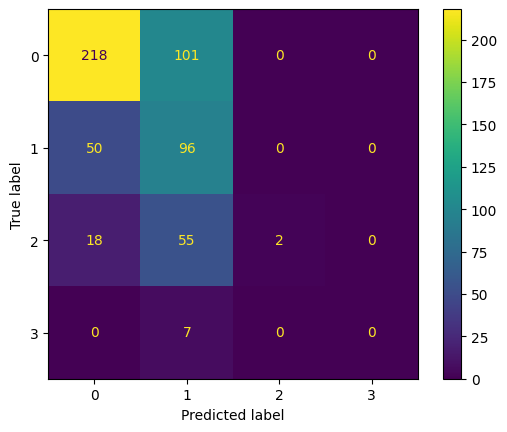

Cohen kappa score across fold: 0.35055290420207197


,Feature,Importance,Value_1,Value_2,Value_3,Value_4,Value_5
1,Internet_Hours_Age,0.205068,0.201809,0.242538,0.128873,0.199446,0.252674
0,Basic_Demos-Age,0.190136,0.193894,0.108753,0.250832,0.237609,0.159594
3,SDS-SDS_Total_Raw,0.071672,0.100349,0.082312,0.043746,0.063926,0.068027
2,SDS-SDS_Total_T,0.070793,0.051010,0.064557,0.106036,0.074903,0.057460
4,Physical-Height,0.038257,0.018338,0.061359,0.046182,0.021091,0.044313
5,BMI_Age,0.028372,0.036916,0.032208,0.031267,0.014913,0.026558
7,Physical-Weight,0.024602,0.030099,0.021786,0.022369,0.020852,0.027905
6,BMI_Internet_Hours,0.023471,0.026837,0.017289,0.029789,0.022332,0.021109
8,Physical-Systolic_BP,0.016398,0.019075,0.018411,0.014041,0.019826,0.010635
9,Physical-HeartRate,0.014675,0.012075,0.014781,0.014891,0.018927,0.012699


Mean Cohen kappa score across 5 folds: 0.35943623663578095


In [41]:
rf_training_predictions = np.zeros((df_train.shape[0],))
rf_training_clipped_predictions = np.zeros((df_train.shape[0],))

if randomforest_on:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    kappa_scores = []
    rf_models = []
    rf_predictions = []
    rf_feature_importance_df = None
    y_true =  y

    i=1
    for train_index, test_index in skf.split(X, y):

        print('fold',i)

        X_train_fold, X_test_fold = numeric_X.iloc[train_index], numeric_X.iloc[test_index]   

        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_true[test_index]

        rf_model =  RandomForestRegressor(
                    max_depth = round(rf_params["max_depth"]),
                    max_samples =rf_params["max_samples"] ,
                    min_samples_split =rf_params["min_samples_split"],
                    min_samples_leaf = rf_params["min_samples_leaf"],
                    n_estimators=round(rf_params["n_estimators"]),
                    random_state=42,
        )


        predictor = rf_model.fit(X_train_fold,
                                      y_train_fold,
                                 )


        rf_models.append(predictor)
        predictions_fold = predictor.predict(X_test_fold)
        rf_training_predictions [test_index]=predictions_fold
        predictions_fold = predictions_fold.clip(y_min, y_max).round()
        rf_predictions.append(predictions_fold)
        rf_training_clipped_predictions [test_index]=predictions_fold

        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(0,4)])

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(0,4)])
        disp.plot()
        plt.show()
        print(f'Cohen kappa score across fold: {kappa_fold}')

        fold_feature_imp = pd.DataFrame({'Feature':numeric_X.columns, f'Value_{i}':predictor.feature_importances_}) 
        rf_feature_importance_df = fold_feature_imp if rf_feature_importance_df is None else rf_feature_importance_df.merge(fold_feature_imp, on = ['Feature'] )      
        value_cols = [ c for c in rf_feature_importance_df.columns if c.startswith('Value_')]
        rf_feature_importance_df["Importance"] = np.mean(rf_feature_importance_df[value_cols], axis = 1)
        rf_feature_importance_df = rf_feature_importance_df.sort_values(by = ["Importance"], ascending = False)
        rf_feature_importance_df = rf_feature_importance_df[["Feature", "Importance"] + [ c for c in rf_feature_importance_df.columns if c.startswith('Value_')]]
        display(rf_feature_importance_df.head(10))       

        i+=1

    mean_kappa_score = np.mean(kappa_scores)

    print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

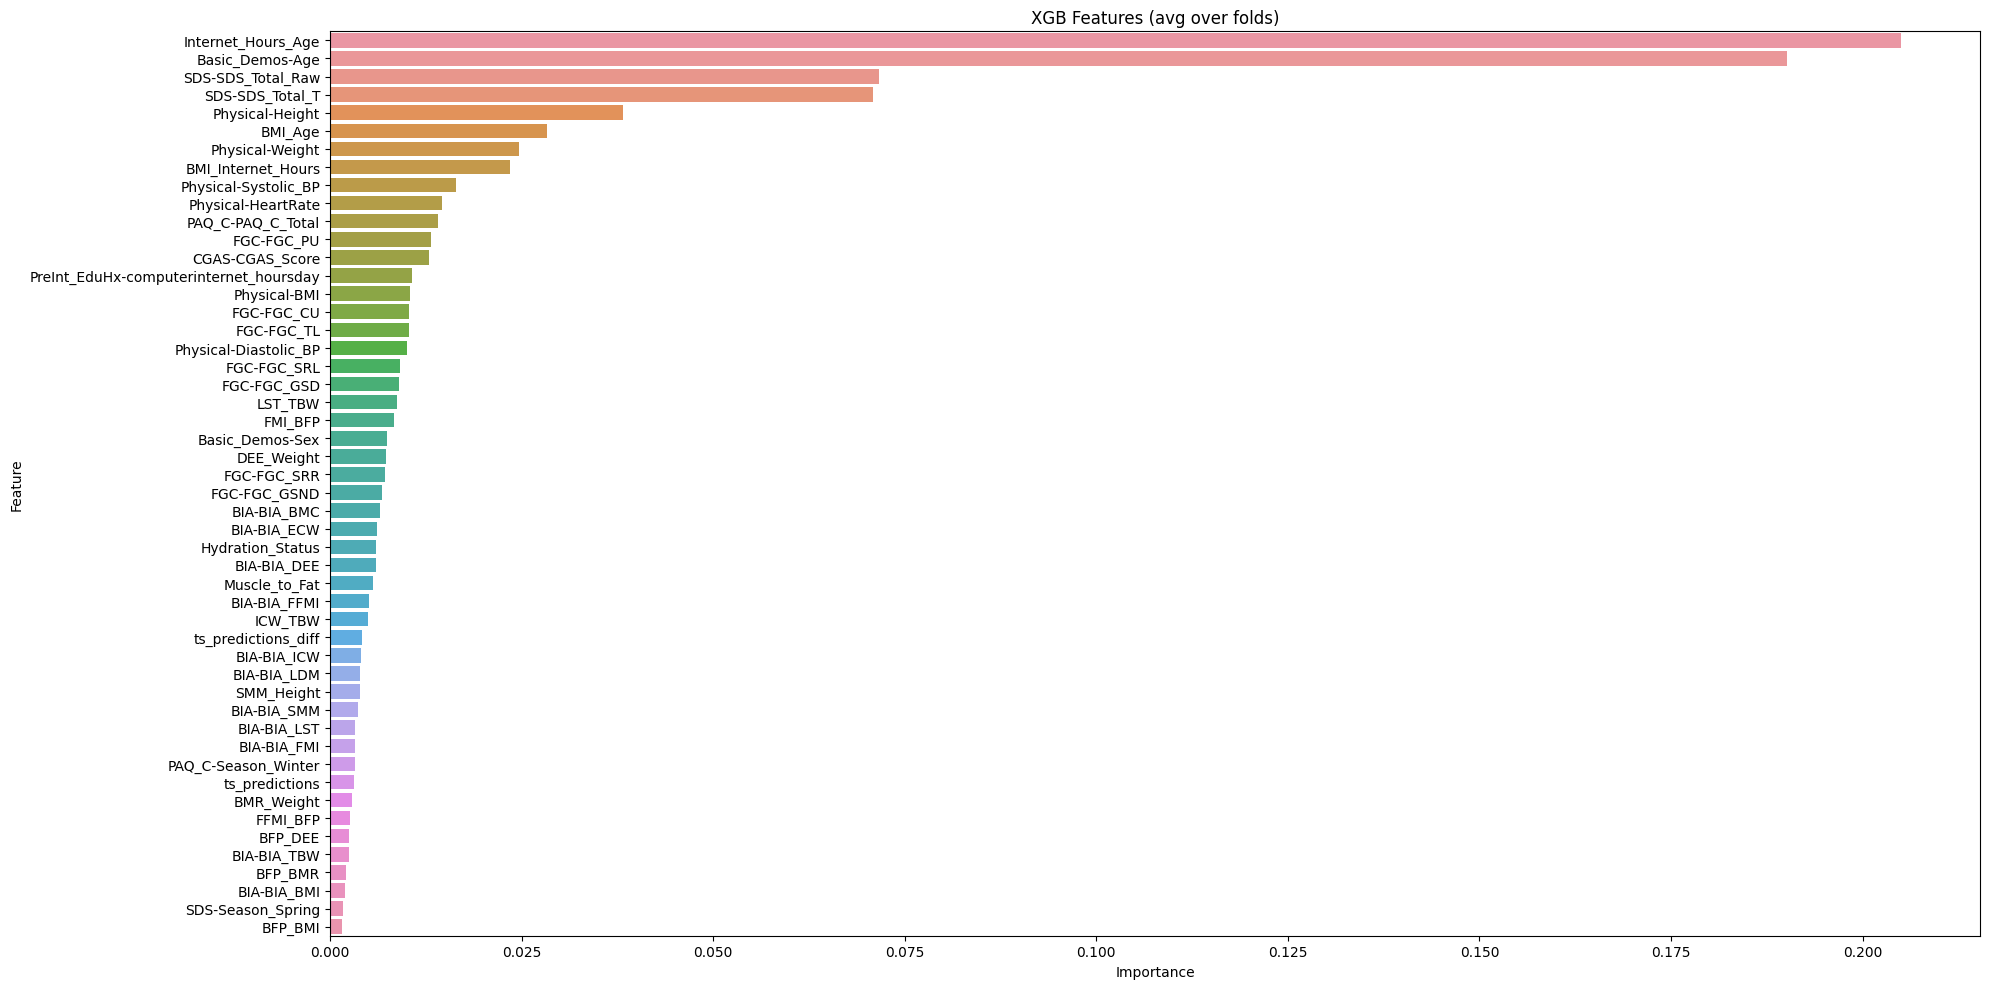

In [42]:
if randomforest_on:
    rf_feature_importance_df.to_csv("/kaggle/working/rf_feature_importance.csv")    
    plt.figure(figsize=(20,10))
    #sns.set(font_scale = 1)
    sns.barplot(x="Importance", y="Feature", data= rf_feature_importance_df[0:50])
    plt.title('XGB Features (avg over folds)')
    plt.tight_layout()
    plt.show()

Ensembloe kappa: 0.3817404922565302


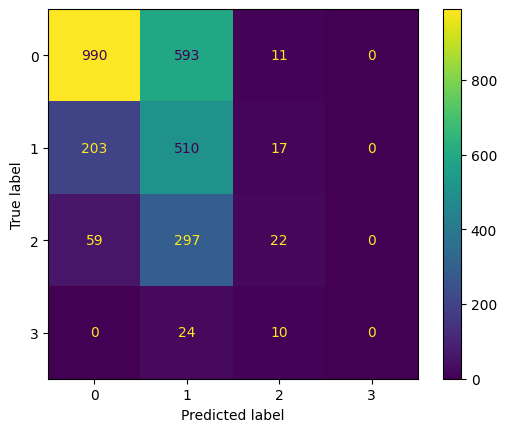

In [43]:
from sklearn.linear_model import LinearRegression
model_count = 1
df_predictions = df_train[["sii"]].copy()
df_predictions["lgbm"]= training_predictions

if xgboost_on:
        df_predictions["xgb"]= xgb_training_predictions


if randomforest_on:
        df_predictions["rf"]= rf_training_predictions
        

ens_training_predictions =  df_predictions.drop("sii", axis=1).mean(axis = 1)

ens_clipped_predictions =  ens_training_predictions.clip(y_min, y_max).round()
kappa_score = cohen_kappa_score(y, ens_clipped_predictions, weights='quadratic')

print("Ensembloe kappa:", kappa_score)

cm = confusion_matrix(y , ens_clipped_predictions, labels=[x for x in range(0,4)])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(0,4)])
disp.plot()

## Threshold optimization

0.4574603298374206
[0.61065779 0.9869213  2.70762201]


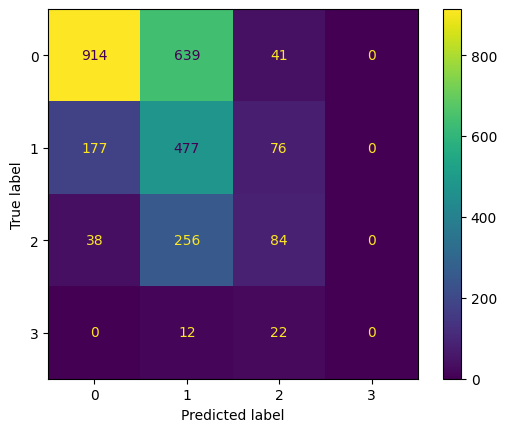

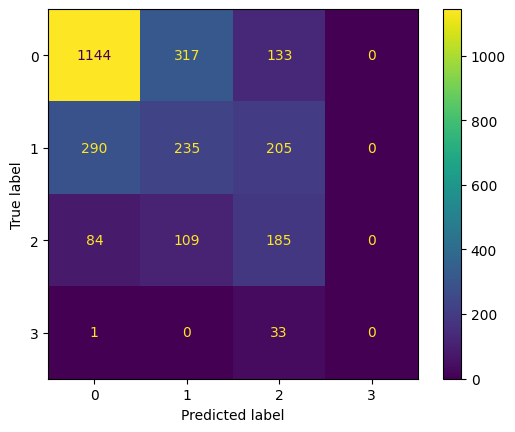

In [44]:
# Copied from https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
from scipy.optimize import minimize

def evaluate_predictions(thresholds, y_true, y_pred):
    rounded_p = threshold_Rounder(y_pred, thresholds)
    return -cohen_kappa_score(y_true, rounded_p, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

cm = confusion_matrix(y , training_clipped_predictions, labels=[x for x in range(0,4)])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(0,4)])
disp.plot()


KappaOPtimizer = minimize(evaluate_predictions,
                          x0=[0.5, 1.5, 2.5], args=(y, ens_training_predictions),  
                          method='Nelder-Mead')


assert KappaOPtimizer.success, "Optimization did not converge."

ens_training_predictions_tuned = threshold_Rounder(ens_training_predictions, KappaOPtimizer.x)
kappa_score = cohen_kappa_score(y, ens_training_predictions_tuned, weights='quadratic') #quadratic_weighted_kappa()
print(kappa_score)

cm = confusion_matrix(y , ens_training_predictions_tuned, labels=[x for x in range(0,4)])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(0,4)])

print(KappaOPtimizer.x)
disp.plot()

# Inference

### Feature extraction on test dataset

In [45]:
# We are basically doing performing the same steps for the test dataset that we did for the training set

test_directory_path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/'
test_ts_df = analyze_ts_files(test_directory_path, gap_threshold)
test_ts_df["id"] = test_ts_df["folder_name"].str[3:]




In [46]:
if time_series_diff_aggregation_on:
    pivot_columns = ['diff_X', 'diff_Y', 'diff_Z', 'diff_enmo', 'diff_anglez', 'diff_light','distance', 'diff_battery_voltage']
    if not filter_wear_flag_on :
        pivot_columns.append('diff_non-wear_flag')
    #pivot_columns = [ 'diff_enmo']
    test_ts_diff_df = test_ts_df[test_ts_df.sequence_breaks <= max_sequence_breaks_diff]
    df_test_ts_diff_features = test_ts_diff_df[["id"]].copy()
    for ts_aggregation in ts_aggregations_diff:
        for pivot_feature in pivot_features_diff:
                df_ts_agg =  timeseries_aggregation_diff(test_ts_diff_df, ts_aggregation,[pivot_feature])    
                df_temp = ts_pivot_by_feature(df_ts_agg, pivot_feature, pivot_columns)
                df_temp.columns = [ 'id'] + [ pivot_feature + '_' + ts_aggregation + '_' + c for c in df_temp.columns if c != 'id']
                df_test_ts_diff_features = df_test_ts_diff_features.merge(df_temp, on = "id", how = "left")

    ts_all_predictions = []
    for model in ts_diff_models:
        fold_prediction = model.predict(df_test_ts_diff_features[ [c for c in df_test_ts_diff_features.columns if c not in ['id']] ])
        ts_all_predictions.append(fold_prediction)           


    #df_test = df_test.merge(df_test_ts_diff_features, on  = "id", how = "left")
    test_ts_diff_df["ts_predictions_diff"] = np.mean(ts_all_predictions, axis=0) 

    df_test = df_test.merge(test_ts_diff_df[["id","ts_predictions_diff"]], on  = "id", how = "left")

In [47]:
if time_series_aggregation_on:
    pivot_columns = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light', 'battery_voltage']
    if not filter_wear_flag_on :
        pivot_columns.append('non-wear_flag')
    test_ts_df = test_ts_df[test_ts_df.sequence_breaks <= max_sequence_breaks]
    df_test_ts_features = test_ts_df[["id"]].copy()
    for ts_aggregation in ts_aggregations:
        for pivot_feature in pivot_features:
                df_ts_agg =  timeseries_aggregation(test_ts_df, ts_aggregation,[pivot_feature])    
                df_temp = ts_pivot_by_feature(df_ts_agg, pivot_feature, pivot_columns)
                df_temp.columns = [ 'id'] + [ pivot_feature + '_' + ts_aggregation + '_' + c for c in df_temp.columns if c != 'id']
                df_test_ts_features = df_test_ts_features.merge(df_temp, on = "id", how = "left")

    ts_all_predictions = []
    for model in ts_models:
        fold_prediction = model.predict(df_test_ts_features[ [c for c in df_test_ts_features.columns if c not in ['id']] ])
        ts_all_predictions.append(fold_prediction)           


    #df_test = df_test.merge(df_test_ts_features, on  = "id", how = "left")
    test_ts_df["ts_predictions"] = np.mean(ts_all_predictions, axis=0) 

    df_test = df_test.merge(test_ts_df[["id","ts_predictions"]], on  = "id", how = "left")

## 

In [48]:
df_test = tabular_feature_engineering(df_test)
print(df_test.shape)
if autoencoder_on:
    
    #df_ts_test_all_features  = df_test_ts_diff_features.merge(df_test_ts_features, on = "id")
    df_ts_test_all_features  = df_test_ts_diff_features #.merge(df_test_ts_features, on = "id")
    cols = [c for c in df_ts_all_features.columns if c not in ["id"]]
    #cols = [ c for c in numeric_cols if c not in [ 'id', 'sii']]
    test_unencoded_df = df_ts_test_all_features[cols].copy()
    print("Auto-encoding ", unencoded_df.shape[0])
    test_unencoded_df.fillna(0, inplace =  True)
    
    test_ts_encoded = perform_autoencoder(test_unencoded_df, encoding_dim=auto_encoder_dimensions, epochs=auto_encoder_epochs, batch_size=64)
    
    
    time_series_cols = train_ts_encoded.columns.tolist()
    test_ts_encoded["id"]=df_ts_test_all_features["id"]
    #test_ts_encoded['id']=test_ts["id"]


    df_train = df_train.merge(train_ts_encoded, on  = "id", how = "left")    

    df_test = df_test.merge(test_ts_encoded, on  = "id", how = "left")

(20, 76)


In [49]:
print(df_test.shape)

(20, 76)


In [50]:
if pca_components > 0:
    df_test_ts_all_features  = df_test_ts_diff_features.merge(df_test_ts_features, on = "id")
    #numeric_cols = df_test_ts_all_features.select_dtypes(include=['float64', 'int64']).columns
    print(df_test_ts_all_features.shape, len(pca_numeric_cols))
    #display(df_ts_diff_features.loc[:, df_ts_diff_features.isnull().any()])
    

    pca_cols = [ c for c in pca_numeric_cols if c not in [ 'id', 'sii']]
    pca_test_X = df_test_ts_all_features[pca_cols].copy()
    pca_test_X.fillna(0, inplace =  True)
    reduced_test_X  = pca.transform(pca_test_X)
    #print(test_pca_components.shape)


    test_pca_df  = pd.DataFrame(reduced_test_X)
    test_pca_df.columns =  pca_columns
    test_pca_df["id"] = test_ts_df["id"]

    df_test = df_test.merge(test_pca_df[ pca_columns + ["id"]] , on  = "id", how = "left")
    
    
    

(2, 2857) 2856


### Prediction

In [51]:
all_predictions = []
#features = [ c for c in df_train.columns if c not in [ "id", "sii"]]
test_numeric_X = pd.get_dummies(df_test[features], columns = categorical_features)
for model in models:
    fold_prediction = model.predict(df_test[features])
    all_predictions.append(fold_prediction)
ar = np.mean(all_predictions, axis=0)
print(df_test.shape,ar.shape)

(20, 126) (20,)


In [52]:
test_numeric_X

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PAQ_C-Season_Summer,PAQ_C-Season_Winter,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter
0,5,0,51.0,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
1,9,0,NaN,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,...,False,False,True,False,False,False,False,False,True,False
2,10,1,71.0,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,...,True,False,True,False,False,False,False,False,True,False
3,9,0,71.0,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,...,False,True,False,False,True,False,False,False,False,True
4,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
5,13,1,50.0,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,...,False,False,False,False,True,False,False,True,False,False
6,10,0,NaN,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,...,False,True,False,False,False,True,True,False,False,False
7,10,1,NaN,16.861286,59.25,84.2,27.0,71.0,90.0,116.0,...,False,False,False,False,False,False,True,False,False,False
8,15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,True,False
9,19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [53]:
all_predictions = []
#features = [ c for c in df_train.columns if c not in [ "id", "sii"]]

test_numeric_X = pd.get_dummies(df_test, columns = categorical_features)
test_numeric_X.fillna(0, inplace = True)
for c in numeric_X.columns:
    if c not in test_numeric_X:
        test_numeric_X[c] = 0
        
test_numeric_X = test_numeric_X[numeric_X.columns]
print(test_numeric_X.shape, numeric_X.shape)

#print ( [ c for c in test_numeric_X.colums if "BIA-Season_Spring])
for model in models:
    fold_prediction = model.predict(df_test[features])
    all_predictions.append(fold_prediction)
df_test["lgbm_predictions"] = np.mean(all_predictions, axis=0)
prediction_cols = ["lgbm_predictions"]


if xgboost_on:
    all_predictions = []
    for model in xgb_models:
        fold_prediction = model.predict(test_numeric_X)
        all_predictions.append(fold_prediction)
    df_test["xgb_predictions"]= np.mean(all_predictions, axis=0)
    prediction_cols.append("xgb_predictions")


if randomforest_on:
    all_predictions = []
    for model in rf_models:
        fold_prediction = model.predict(test_numeric_X)
        all_predictions.append(fold_prediction)
    df_test["rf_predictions"]= np.mean(all_predictions, axis=0)
    prediction_cols.append("rf_predictions")
    

ens_test_predictions =  df_test[prediction_cols].mean(axis = 1)    
print(ens_test_predictions.shape)
    

if threshold_optimization_on:
    test_predictions = threshold_Rounder( ens_test_predictions, KappaOPtimizer.x)
else:
    test_predictions = ens_test_predictions

print(ens_test_predictions[:20])
clipped_predictions = test_predictions.clip(y_min, y_max).round().astype(np.int32)
print(clipped_predictions[:20])

(20, 155) (2736, 155)
(20,)
0     0.510215
1     0.285683
2     0.561301
3     0.366357
4     0.556295
5     0.616973
6     0.709923
7     0.424657
8     0.825121
9     0.555127
10    0.490592
11    0.534838
12    0.859946
13    0.574460
14    0.788231
15    0.636745
16    0.173589
17    0.454498
18    0.505896
19    0.612196
dtype: float64
[0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1]


In [54]:
#test_numeric_X ["BIA-Season_Spring"]

### Submission

In [55]:
df_submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
df_submission['sii'] = clipped_predictions
df_submission['sii'] = df_submission['sii'].astype(int)
df_submission.to_csv("submission.csv",index=None)
display(df_submission.head())

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0


<Axes: >

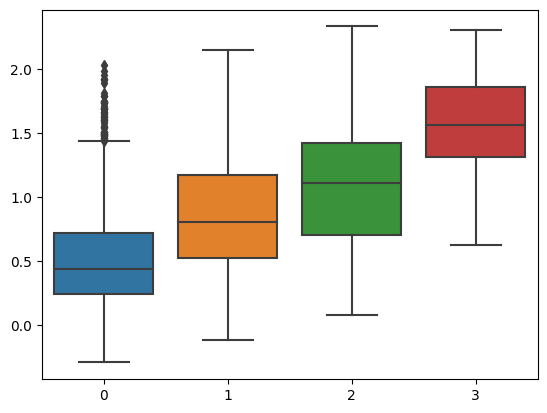

In [56]:
sns.boxplot (x=y_true , y =training_predictions)

Ucomment and run this line if you are changing any of the cached features.

In [57]:
#!rm /kaggle/working/ts_diff_features*
#!rm /kaggle/working/*

In [58]:
#df_ts_features.X1_12.describe()
    
#sns.scatterplot(x= "enmo_18", y = "sii", data = df_train)